# Conditional GAN - Testing using Black-Scholes data.

This notebook is a sample of the work done during my thesis project. I use some figures in this notebook in the results section of my MSc. Thesis, specifically Section 5.1, which can be found at the following link: https://github.com/RDS-95/portfolio/blob/main/GANs-MScThesis.pdf

The complete PDF also contains many sources for the information discussed here. 

## Motivation

Asset returns in finance are unpredictable. They are subject to exogenous circumstances such as business news, political events, and pandemics. Even so, when examining returns data statistically, it consistently exhibits the same set of non-trivial properties known in the literature as stylized facts. Collecting all these properties together results in a hugely challenging process to model, to the vexation of many investors, as the pricing of options contracts relies on an accurate way to replicate the behaviour of the underlying asset. Here, as a potential solution to the modelling problem, we turn to the field of deep learning and, in particular, GANs.

## Introduction to GANs

Generative adversarial networks (GANs) undertake a purely data-driven approach to modelling their training sets. It can be summarized as follows: One neural network, the generator, is set up to produce synthetic data. Another neural network, the discriminator, is set up to determine whether the data it receives comes from the real data set or the generator. By pitting these two networks against each other in a zero-sum game, we grow the capability of both, resulting in a generator that can produce outputs mimicking the properties of the training data almost exactly. GANs have shown a remarkable aptitude for modelling complex dependencies in images and videos and have more recently been successfully applied to time series data. Some prominent examples of GANs applied to financial time series are QuantGAN and FIN-GAN, although the architecture used in these GANs is complex and computationally intensive to train. 

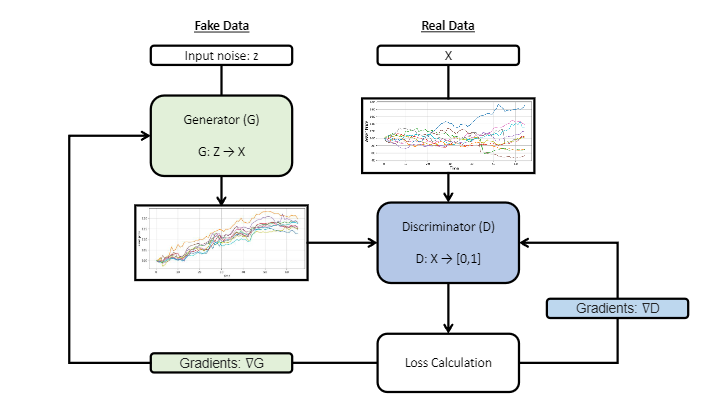

## Conditional Generation

In this notebook, we show that these GANs can be extended to a conditional framework for financial time series. Conditioning allows us to tune model parameters like volatility or interest rate to reflect current market climates. We show that even using (relative to convention) extremely shallow neural networks, the GAN can make inferences about these model parameters and produce statistically appropriate outputs. We first generate data using the Black-Scholes SDE, giving a range of values for the parameter upon which our cGAN will be conditioned. Once the cGAN has been trained, we investigate whether our cGAN has inferred the appropriate effect of each condition by examining its outputs.


In [3]:
import custom_functions

from tensorflow.python.client import device_lib 
import warnings
import statistics

import math
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from pandas_datareader import data
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow import keras
import time

import pydot
warnings.filterwarnings("ignore")
     

C:\Users\rudys\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Generating the Training Set

#### Black-Scholes Model

Indisputably the most famous model in financial mathematics, the Black-Scholes model incorporates the idea of geometric Brownian motion to capture the stochastic nature of asset prices. To understand why this makes sense, we can look to the efficient market hypothesis espoused by Malkiel. This theory simply states that the current asset price reflects all past information on the asset. Thus, when considering what the price may be tomorrow, we gain no advantage in looking at the asset price at any other time but today. The Black-Scholes model (along with many other models) reflects this by modeling the asset price $S$ as a Markovian process using the following stochastic differential equation:

$$ dS_t = \mu S_tdt + \sigma S_tdW_t $$

Where $\mu$ is the drift, $\sigma$ is the volatility and $W_t$ is a Wiener process (1-dim Brownian motion here). By applying Ito's Lemma, we get the solution of the SDE as

$$S_t = S_0 \textrm{exp}[(\mu - \frac{1}{2} \sigma ^2)t + \sigma \sqrt{t} Z]$$

Where Z is a standard normal random variable.

In [559]:
S0 = 100 #initial asset price
r = 0.2 #constant short rate

#creating 10 different sigma values
sigmas = [0.001,0.01,0.1,1]

T = 2.0 #time in years

I = 2500 #no. of random draws
M = 64 # highly divisible. Easier to build model with this.
dt = T / M
Sv = np.zeros((len(sigmas), M+1, I))
Sv[:, 0, :] = S0 

#for each sigma, want 1000 processes generated.

for i, sigma in enumerate(sigmas):
    for t in range(1, M+1):
        S_last = Sv[i, t-1]  # Last asset prices
        S_new = S_last * np.exp((r - 0.5*sigma**2) * dt
                                + sigma * np.sqrt(dt) * npr.standard_normal(I))
        Sv[i, t] = S_new

stacked_asset_paths = Sv.reshape((len(sigmas) * I, M+1))

In [560]:
log_returns_array = np.zeros_like(Sv)

for i in range(4):  # i in [0, 4]
    for j in range(2500):  # j in [0, 999]
        for k in range(1, Sv.shape[1]):
            log_returns_array[i, k, j] = np.log(Sv[i, k, j] / Sv[i, k - 1, j])

In [561]:
stacked_logret_paths = log_returns_array.reshape((len(sigmas) * I, M+1))

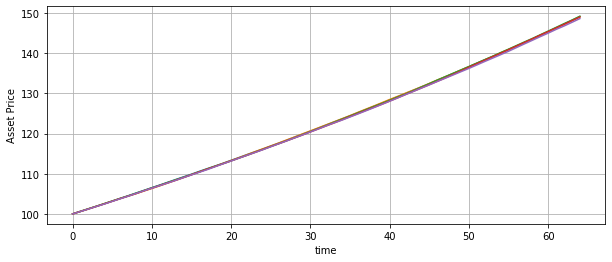

In [566]:
plt.figure(figsize=(10,4))
plt.plot(Sv[0, :, :5], lw=1.5) #y plots of 0.x volatility sim for log_returns_array[x,:,:y]
plt.xlabel("time")
plt.ylabel("Asset Price")
plt.grid(True)

#### Preprocess data for use in the CGAN

Here we attach labels to each of the generated time series. The label is the sigma value which was used to generate that time series.

In [577]:
sigma_values = np.repeat(sigmas, I)
sigma_values = sigma_values[:,None]

In [578]:
stacked_asset_paths = np.reshape(stacked_asset_paths, (-1, 65, 1))
stacked_asset_paths.shape

(10000, 65, 1)

In [579]:
dataset = tf.data.Dataset.from_tensor_slices((stacked_asset_paths, sigma_values))
dataset = dataset.shuffle(buffer_size=10000).batch(32)

#### Building the GAN Model

We strive to make the model as simple as possible here. Since Black-Scholes data is markovian, without any complex dependencies, it stands to reason that we will not need a complex model. We are primarily concerned with demonstrating the conditional learning capabilities of GANs in this notebook, rather than creating the most powerful model.

In [704]:
batch_size = 32
data_dim = 65
noise_dim = 50
data_channels = 1
num_conditions = 1

gen_in_channels = noise_dim + num_conditions 
disc_in_channels = data_channels + num_conditions
  
def make_generator_model():
    
    g_kernel = 5
    gf_dim = 64
    act = layers.ReLU

    model = tf.keras.Sequential()

    model.add(layers.Dense(data_dim * gf_dim, input_shape=(gen_in_channels,)))
    model.add(layers.Reshape((data_dim//1, gf_dim*1)))
    model.add(layers.BatchNormalization())
    
    model.add(act())
    model.add(layers.Conv1DTranspose(data_channels, g_kernel, strides=1, padding='same', activation= 'linear'))
    
    return model

generator = make_generator_model()

In [705]:
generator.summary()

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 4160)              216320    
                                                                 
 reshape_57 (Reshape)        (None, 65, 64)            0         
                                                                 
 batch_normalization_80 (Bat  (None, 65, 64)           256       
 chNormalization)                                                
                                                                 
 re_lu_63 (ReLU)             (None, 65, 64)            0         
                                                                 
 conv1d_transpose_60 (Conv1D  (None, 65, 1)            321       
 Transpose)                                                      
                                                                 
Total params: 216,897
Trainable params: 216,769
Non-

In [706]:
def make_discriminator_model():
    
    d_kernel = 5
    df_dim = 32

    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(data_dim, disc_in_channels)))
    
    model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1D(df_dim*2, d_kernel, strides=2, padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
        
    model.add(layers.Flatten())
    model.add(layers.Dense(1, use_bias=False))
        
    return model

discriminator = make_discriminator_model()

In [707]:
discriminator.summary()

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 33, 32)            352       
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 33, 32)            0         
                                                                 
 conv1d_58 (Conv1D)          (None, 17, 64)            10304     
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 17, 64)            0         
                                                                 
 flatten_47 (Flatten)        (None, 1088)              0         
                                                                 
 dense_105 (Dense)           (None, 1)                 1088      
                                                                 
Total params: 11,744
Trainable params: 11,744
Non-tr

In [708]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

In [709]:
@tf.function

def train_step(data):
    
    #Everything between here and the next line below is added as preprocessing for CGAN.
    #-------------------------------------------------------------------------------------
    
    #unpack the sequences and volatilities
    real_series, volatilities = data
    
    #dtype fix.
    real_series = tf.cast(real_series, tf.float32)
    
    # Add dummy dimensions to the labels so that they can be concatenated with
    # the sequences. This is for the discriminator.
    
    series_volatilities = volatilities[:, :, None, None]
    series_volatilities = tf.repeat(
            series_volatilities, repeats=[data_dim]
        )
    series_volatilities = tf.reshape(
            series_volatilities, (-1, data_dim, num_conditions)
        )
    
    #need to concat noise with volatility label for input into generator
    
    batch_size = tf.shape(real_series)[0]
        
    noise = tf.random.normal([batch_size, noise_dim])

    noise_with_labels = tf.concat(
        [noise,  tf.cast(volatilities, dtype=tf.float32)], axis=1
    )
    
    #------------------------------------------------------------------------------------- 
    
    #enter the training step:

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Decode the noise (guided by labels) to fake series.
        fake_series = generator(noise_with_labels, training=True)
        
        # Combine them with real series. Note that we are concatenating the labels with these series here.
                                
        fake_series_and_labels = tf.concat([fake_series, 
                                            tf.cast(series_volatilities, dtype=tf.float32)], -1)
        
        real_series_and_labels = tf.concat([real_series,
                                            tf.cast(series_volatilities, dtype=tf.float32)], -1)

        real_output = discriminator(real_series_and_labels, training=True)
        fake_output = discriminator(fake_series_and_labels, training=True)

        gen_loss = custom_functions.generator_loss(fake_output)
        disc_loss = custom_functions.discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    
    for epoch in range(epochs):
        start = time.time()

        G_list = []; D_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            G_list.append(gen_loss)
            D_list.append(disc_loss) 

        G_loss.append(np.mean(G_list))
        D_loss.append(np.mean(D_list))

        custom_functions.plot_loss(G_loss, D_loss)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [710]:
train_dataset = dataset

In [711]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 65, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

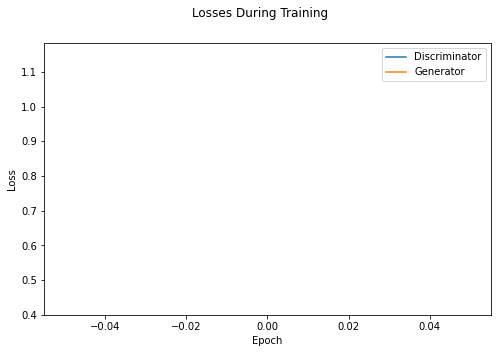

Time for epoch 1 is 6.427875280380249 sec


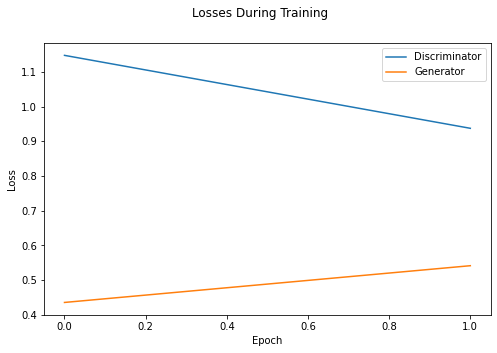

Time for epoch 2 is 2.957475185394287 sec


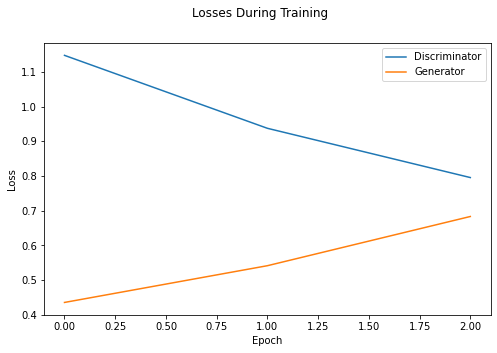

Time for epoch 3 is 2.390364170074463 sec


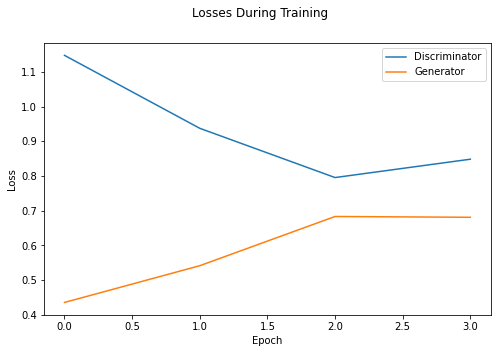

Time for epoch 4 is 1.9395523071289062 sec


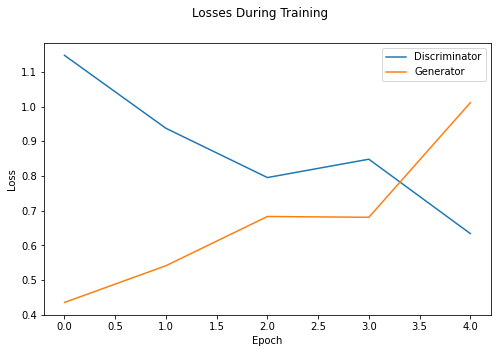

Time for epoch 5 is 1.9618303775787354 sec


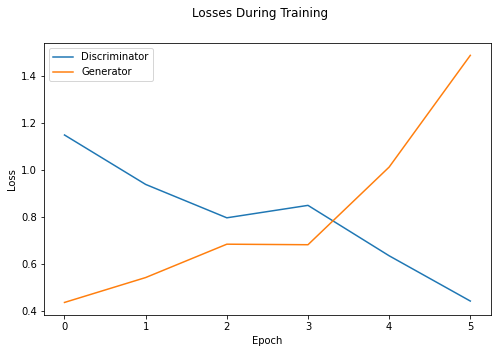

Time for epoch 6 is 1.9062697887420654 sec


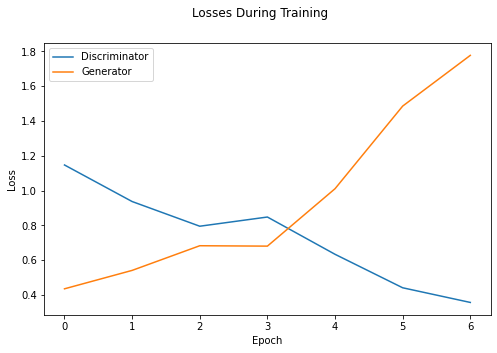

Time for epoch 7 is 1.9443230628967285 sec


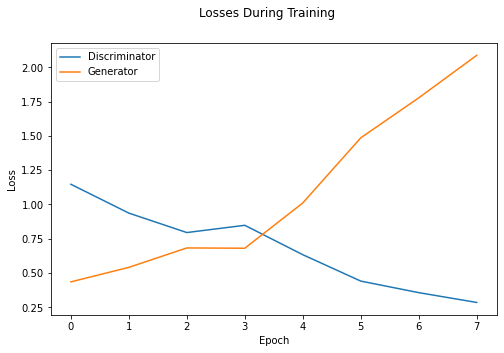

Time for epoch 8 is 1.8996970653533936 sec


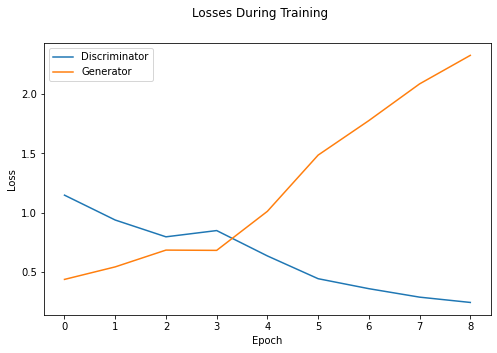

Time for epoch 9 is 1.9502382278442383 sec


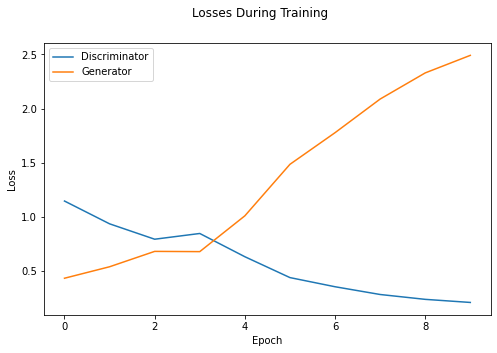

Time for epoch 10 is 1.9209318161010742 sec


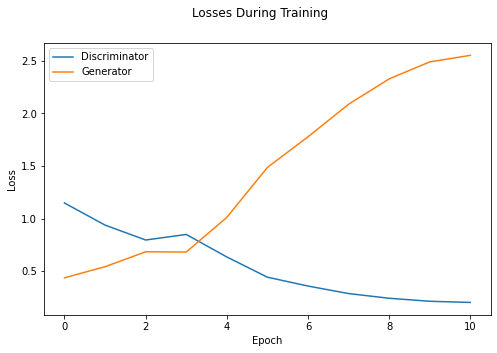

Time for epoch 11 is 1.8628747463226318 sec


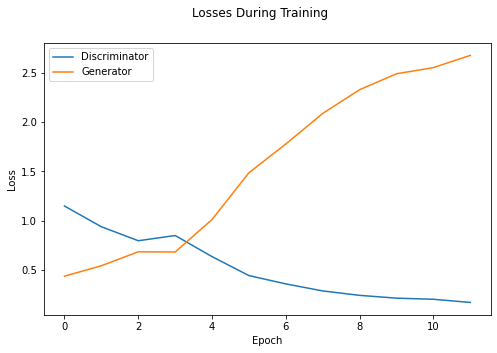

Time for epoch 12 is 1.83573317527771 sec


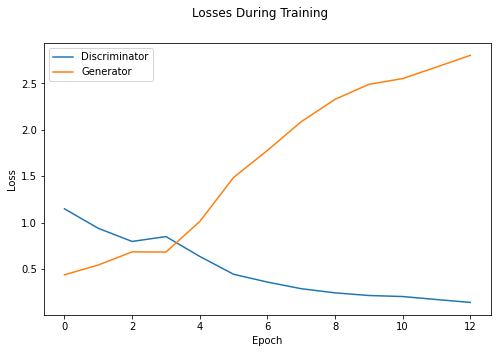

Time for epoch 13 is 1.8674101829528809 sec


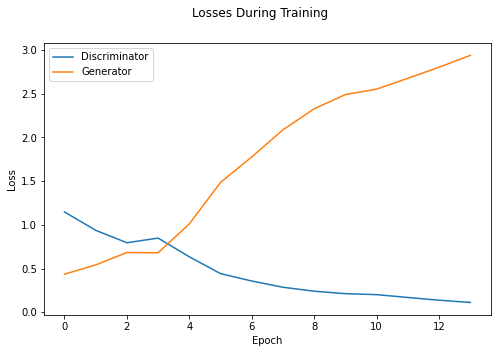

Time for epoch 14 is 1.8575644493103027 sec


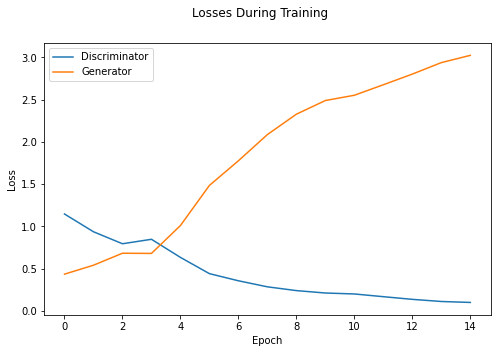

Time for epoch 15 is 1.863548755645752 sec


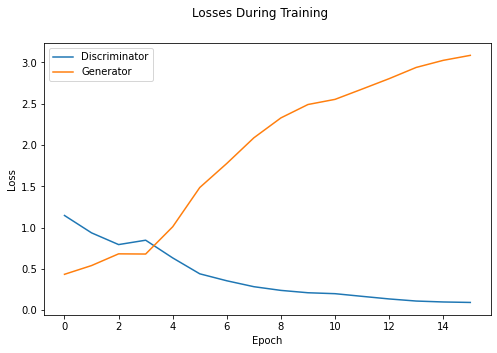

Time for epoch 16 is 1.9094038009643555 sec


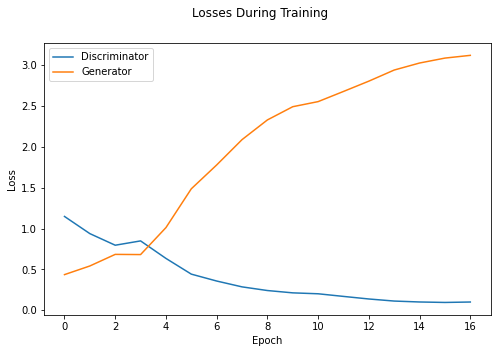

Time for epoch 17 is 1.9247145652770996 sec


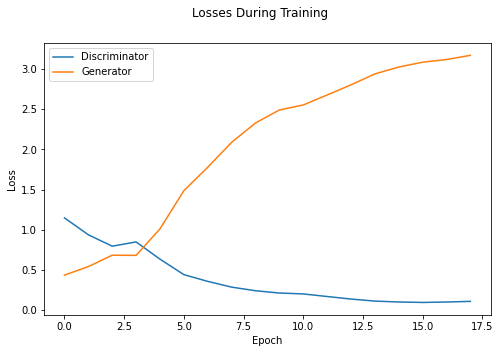

Time for epoch 18 is 1.8618299961090088 sec


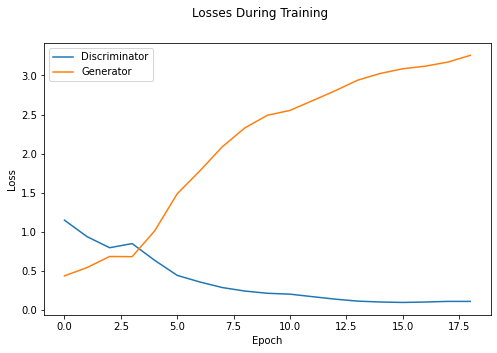

Time for epoch 19 is 1.8631343841552734 sec


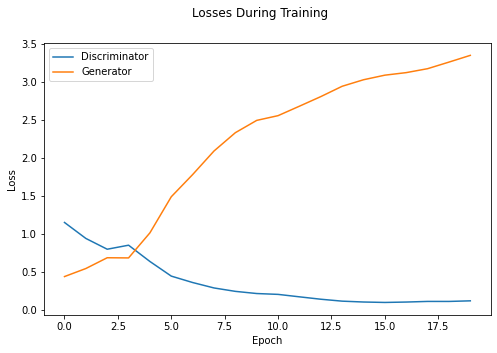

Time for epoch 20 is 1.8097732067108154 sec


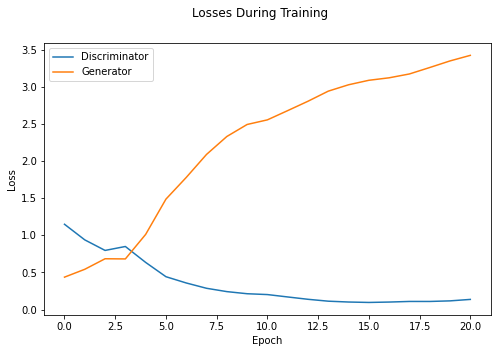

Time for epoch 21 is 1.8425180912017822 sec


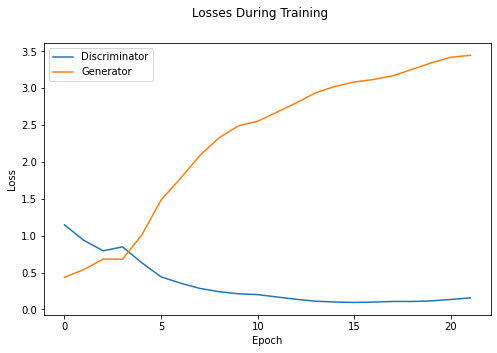

Time for epoch 22 is 1.8102452754974365 sec


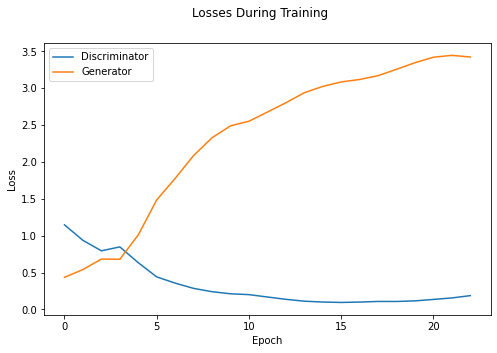

Time for epoch 23 is 1.8750114440917969 sec


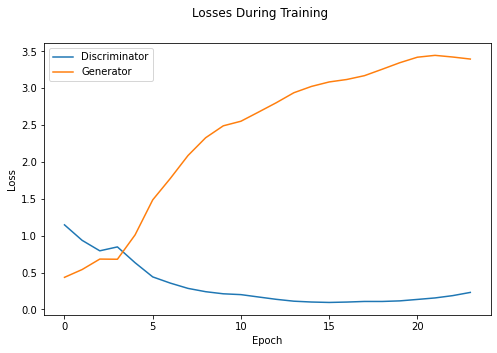

Time for epoch 24 is 3.3340940475463867 sec


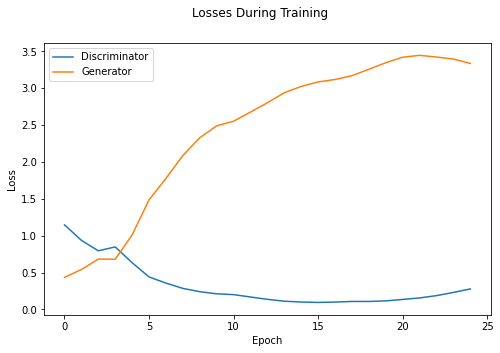

Time for epoch 25 is 1.822981834411621 sec


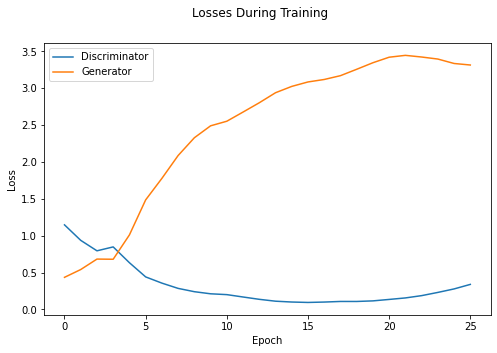

Time for epoch 26 is 1.7924461364746094 sec


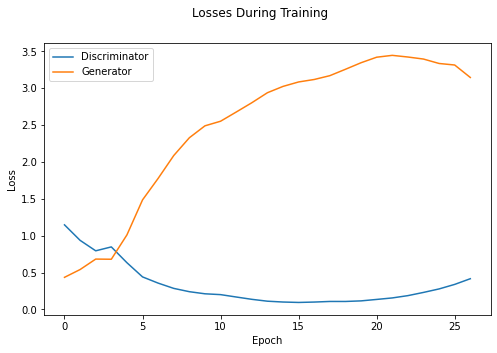

Time for epoch 27 is 1.7750108242034912 sec


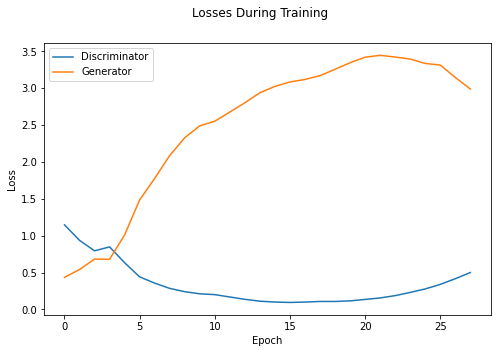

Time for epoch 28 is 2.5416362285614014 sec


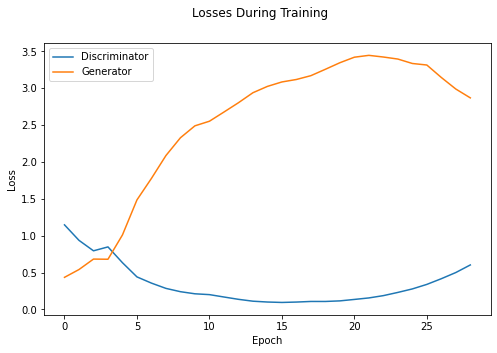

Time for epoch 29 is 1.9821906089782715 sec


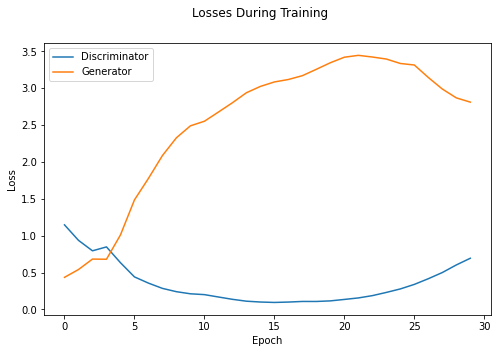

Time for epoch 30 is 1.79402756690979 sec


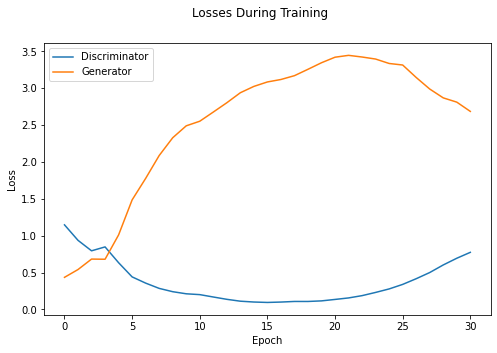

Time for epoch 31 is 1.8085622787475586 sec


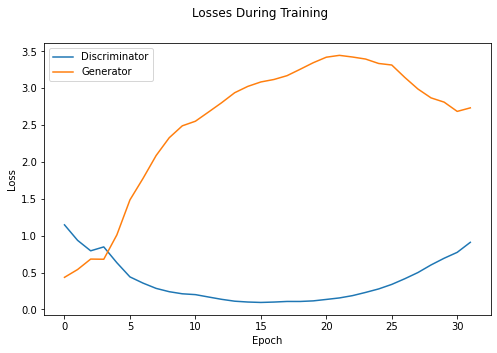

Time for epoch 32 is 1.8154575824737549 sec


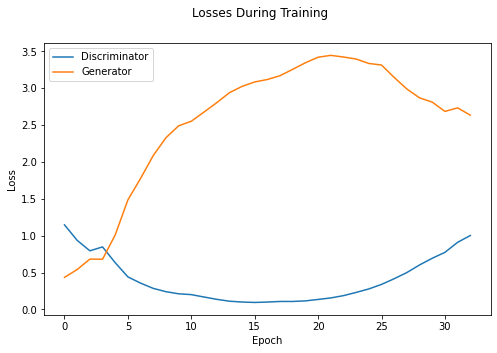

Time for epoch 33 is 1.7952678203582764 sec


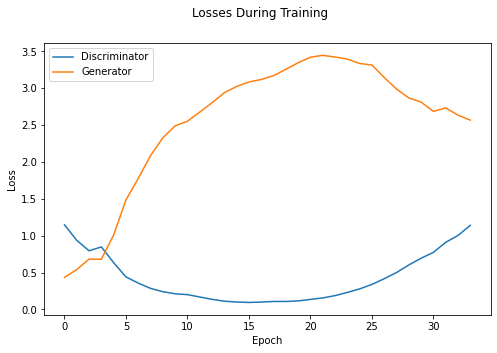

Time for epoch 34 is 1.8401002883911133 sec


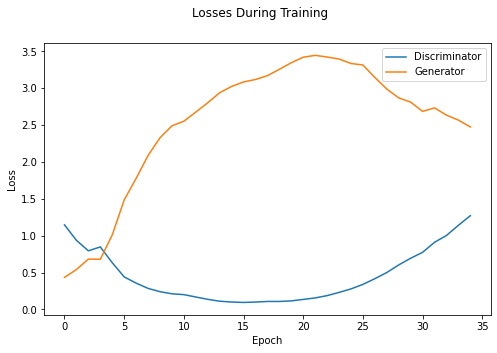

Time for epoch 35 is 1.7899901866912842 sec


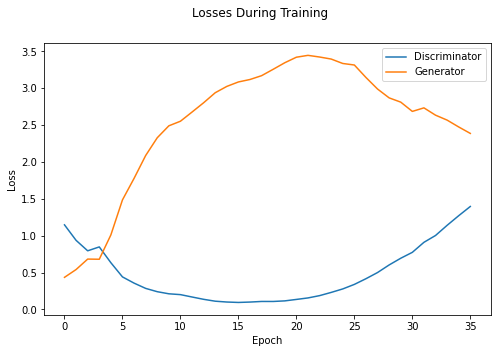

Time for epoch 36 is 1.8104069232940674 sec


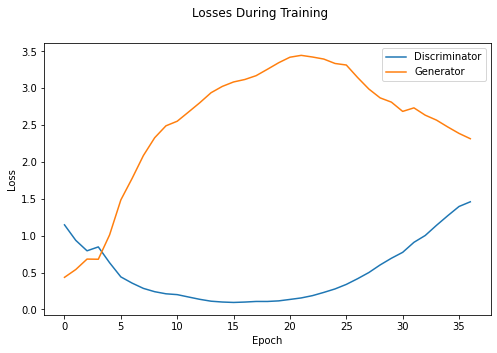

Time for epoch 37 is 1.7686195373535156 sec


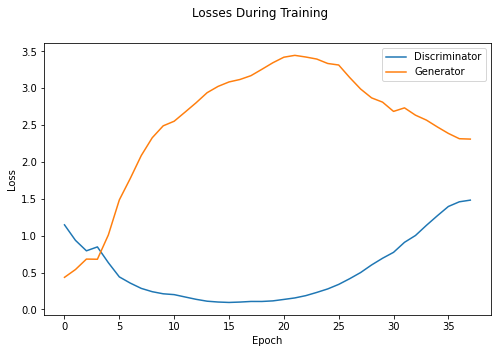

Time for epoch 38 is 3.7608118057250977 sec


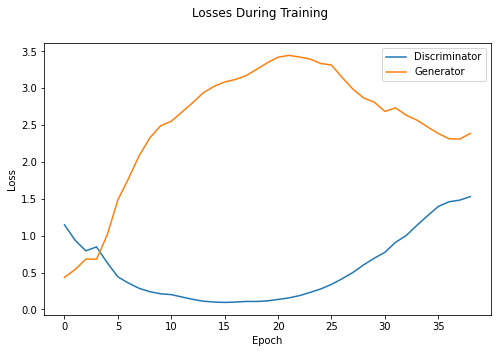

Time for epoch 39 is 1.7625892162322998 sec


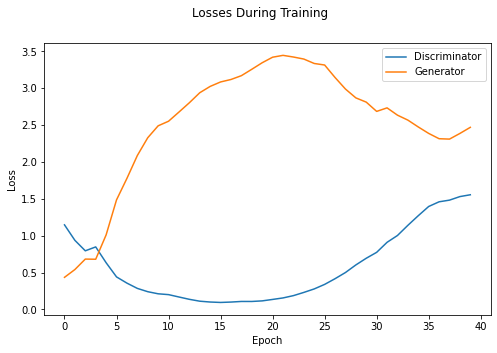

Time for epoch 40 is 1.7678675651550293 sec


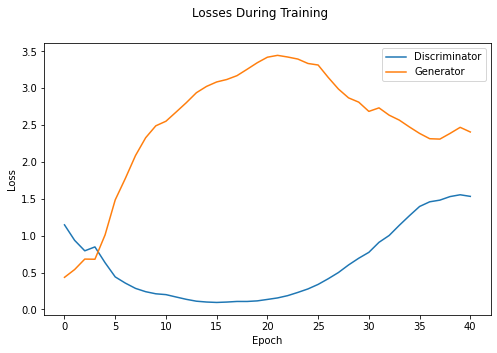

Time for epoch 41 is 1.7485034465789795 sec


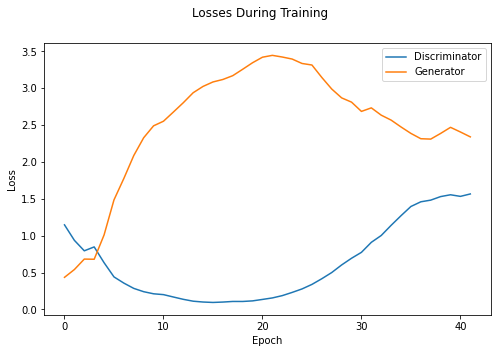

Time for epoch 42 is 1.701444149017334 sec


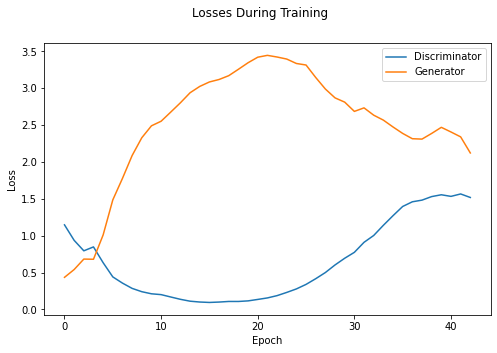

Time for epoch 43 is 1.705322265625 sec


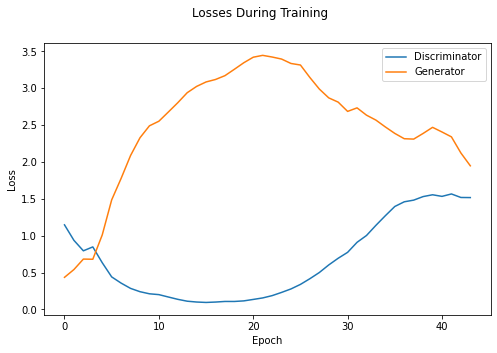

Time for epoch 44 is 1.7018046379089355 sec


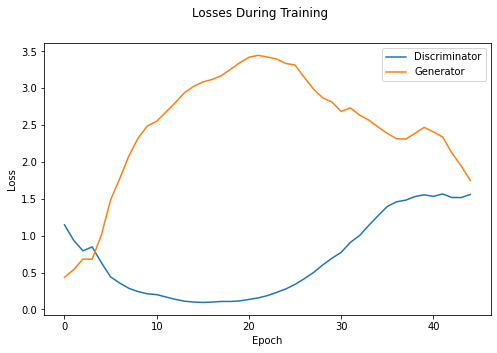

Time for epoch 45 is 3.266603946685791 sec


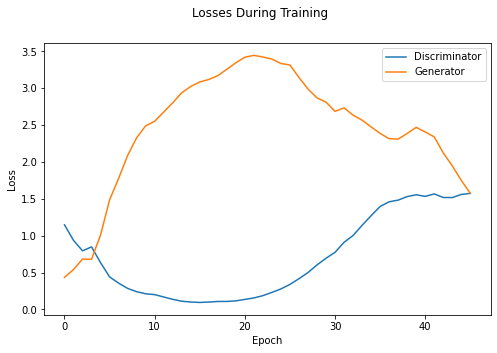

Time for epoch 46 is 3.4239330291748047 sec


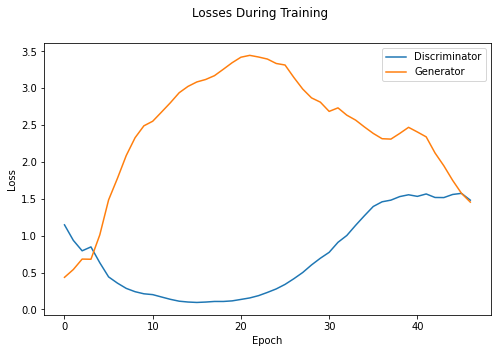

Time for epoch 47 is 1.6847426891326904 sec


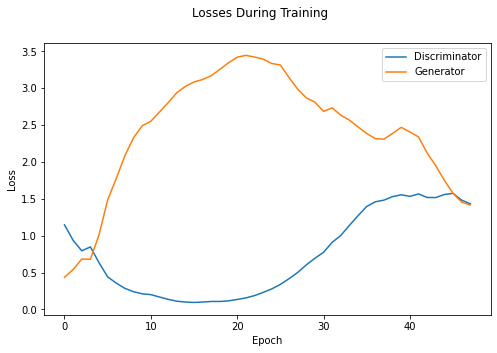

Time for epoch 48 is 3.6193976402282715 sec


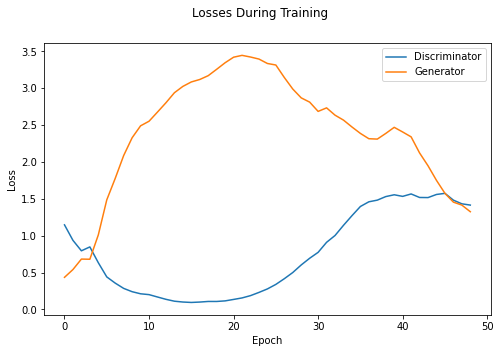

Time for epoch 49 is 1.701761245727539 sec


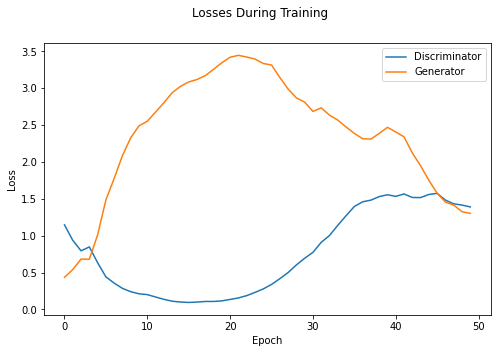

Time for epoch 50 is 2.22940731048584 sec


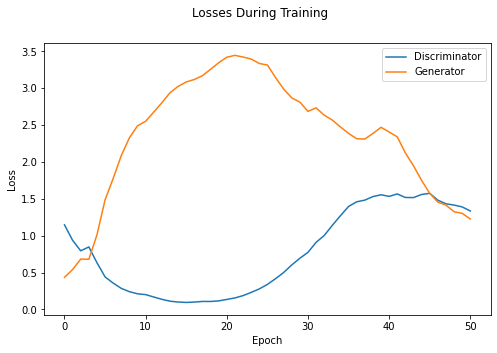

Time for epoch 51 is 1.9781606197357178 sec


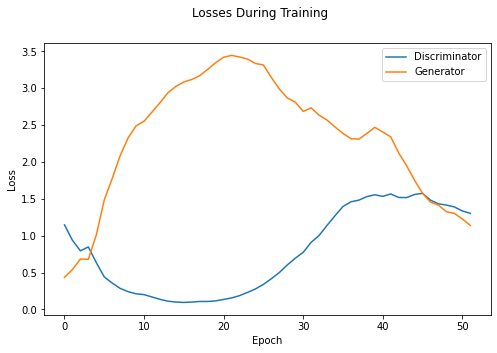

Time for epoch 52 is 1.9478609561920166 sec


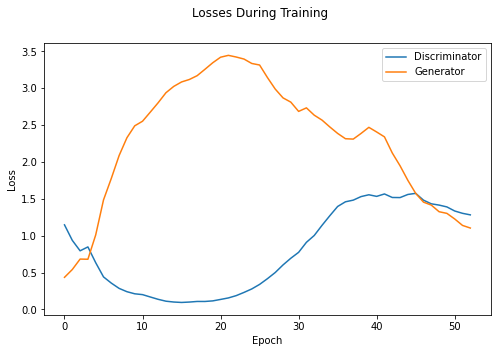

Time for epoch 53 is 1.9216625690460205 sec


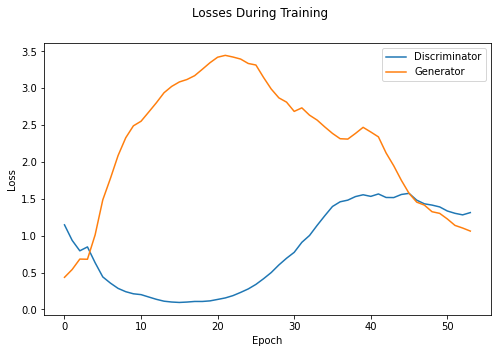

Time for epoch 54 is 1.9289932250976562 sec


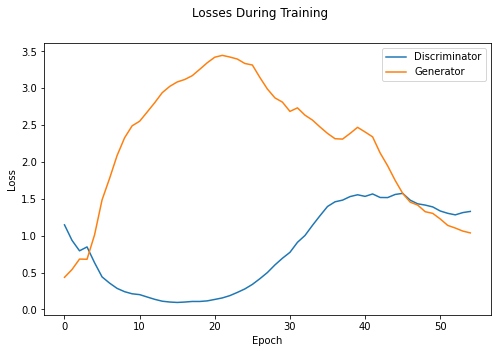

Time for epoch 55 is 3.5068039894104004 sec


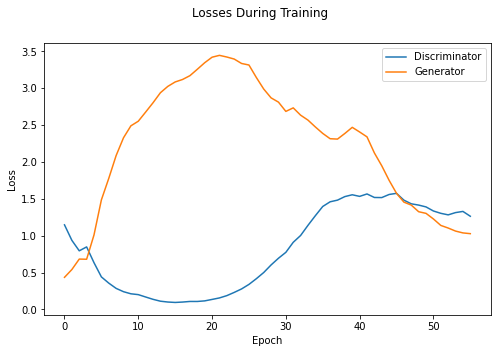

Time for epoch 56 is 1.916597604751587 sec


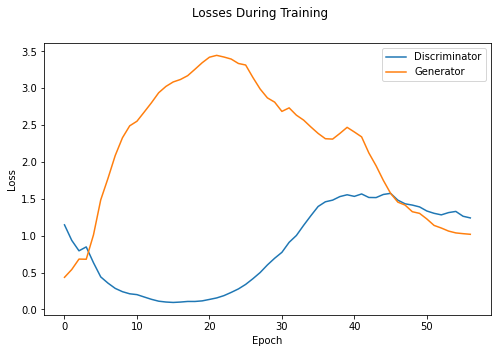

Time for epoch 57 is 1.9213435649871826 sec


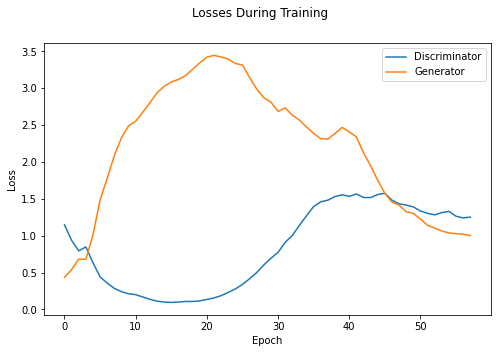

Time for epoch 58 is 1.869910717010498 sec


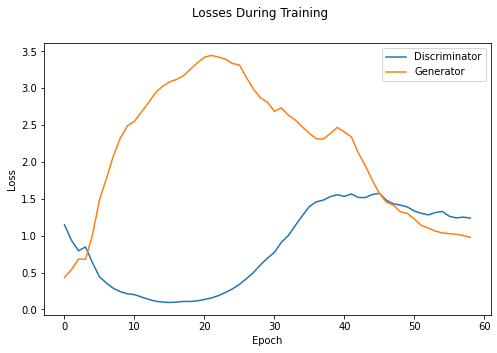

Time for epoch 59 is 1.9269628524780273 sec


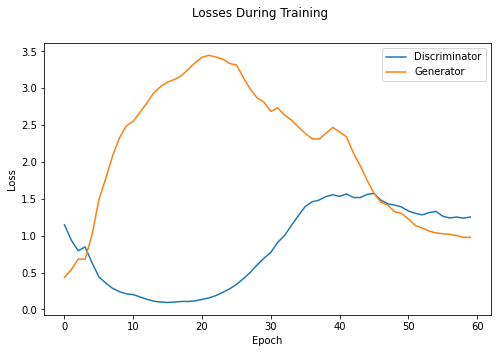

Time for epoch 60 is 1.9509985446929932 sec


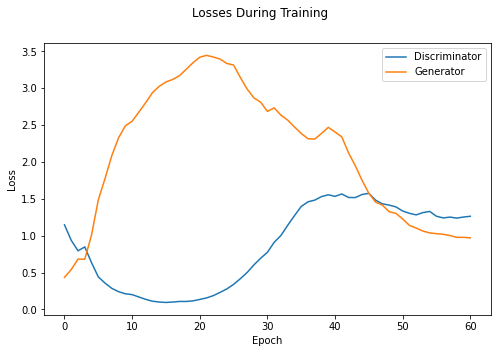

Time for epoch 61 is 2.8476638793945312 sec


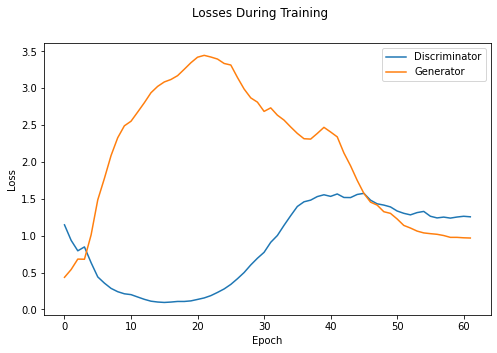

Time for epoch 62 is 3.3750851154327393 sec


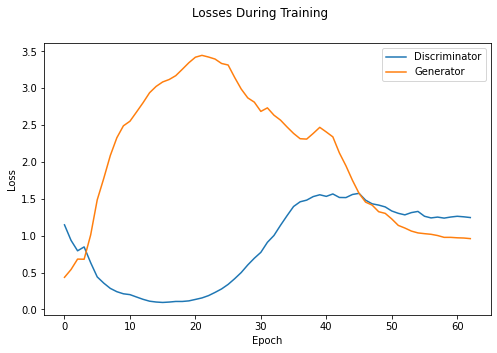

Time for epoch 63 is 1.838533878326416 sec


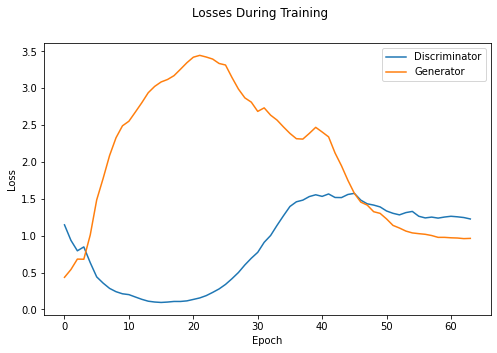

Time for epoch 64 is 4.154837131500244 sec


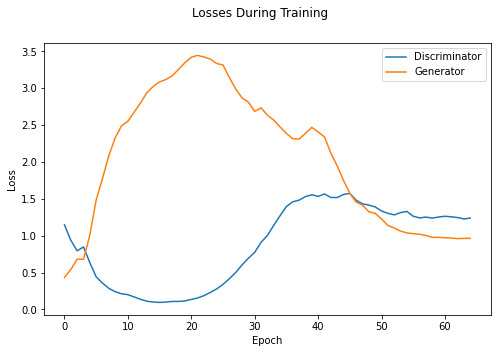

Time for epoch 65 is 1.8598766326904297 sec


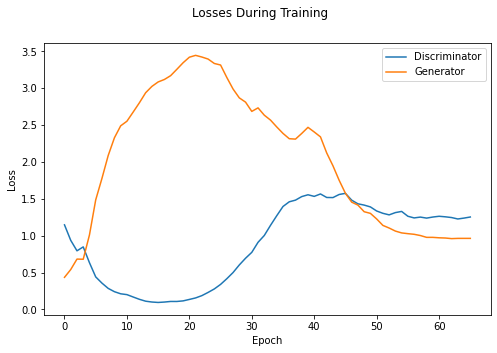

Time for epoch 66 is 1.887704849243164 sec


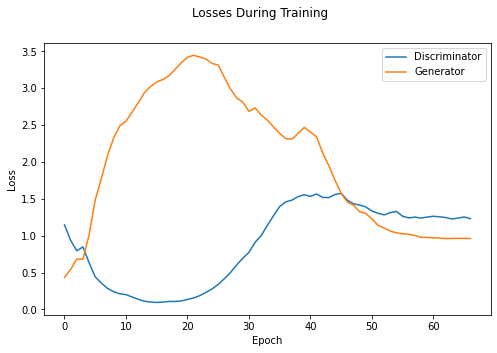

Time for epoch 67 is 1.860656499862671 sec


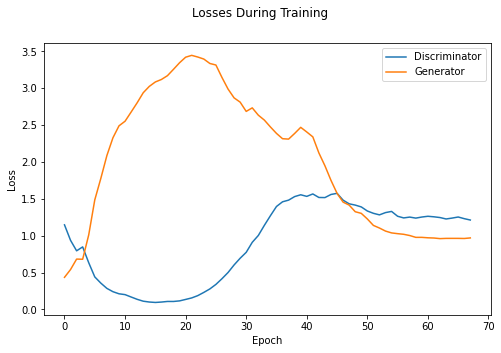

Time for epoch 68 is 1.818523645401001 sec


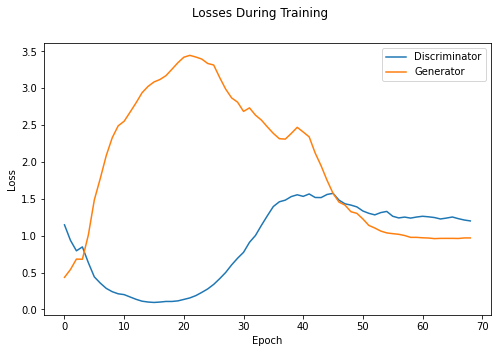

Time for epoch 69 is 1.8741133213043213 sec


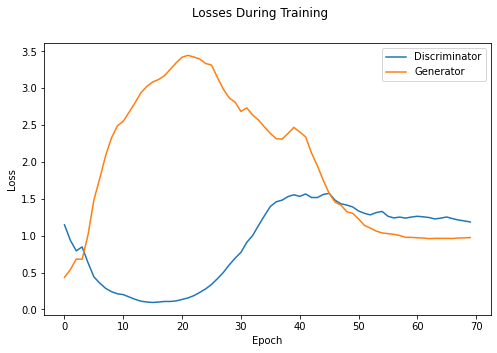

Time for epoch 70 is 1.8190577030181885 sec


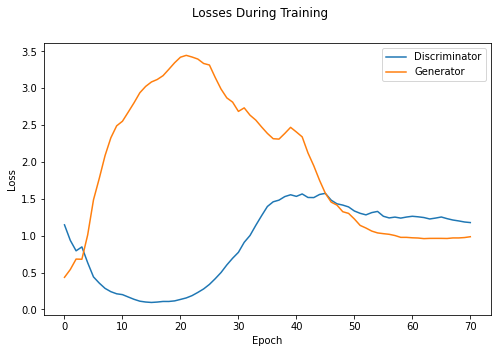

Time for epoch 71 is 3.6582179069519043 sec


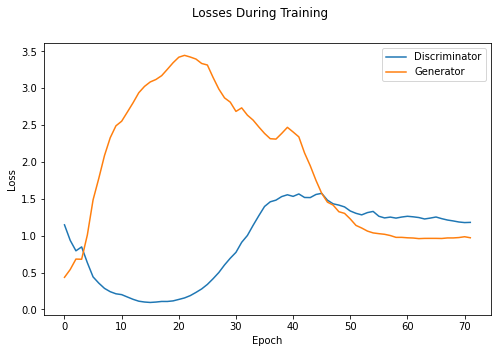

Time for epoch 72 is 1.8543331623077393 sec


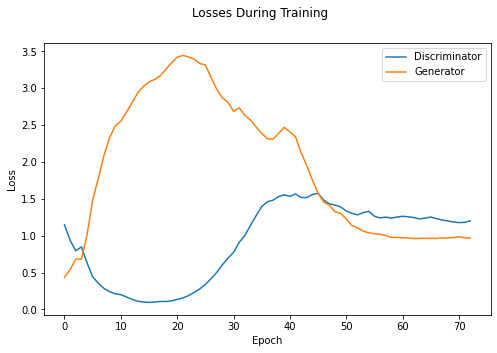

Time for epoch 73 is 1.8475286960601807 sec


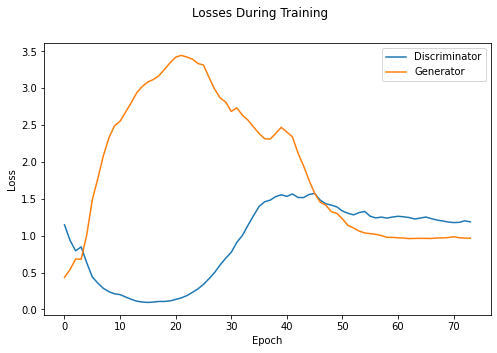

Time for epoch 74 is 1.8486299514770508 sec


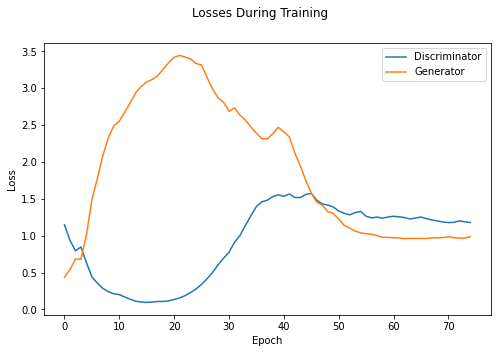

Time for epoch 75 is 1.8060073852539062 sec


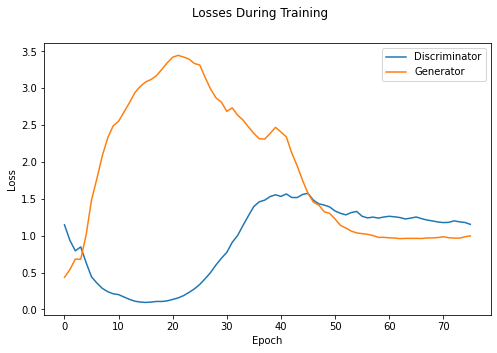

Time for epoch 76 is 1.8243408203125 sec


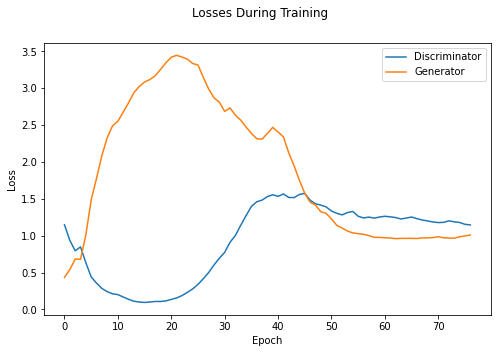

Time for epoch 77 is 1.798567295074463 sec


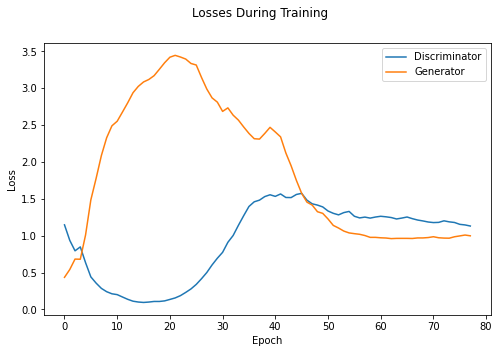

Time for epoch 78 is 1.8114991188049316 sec


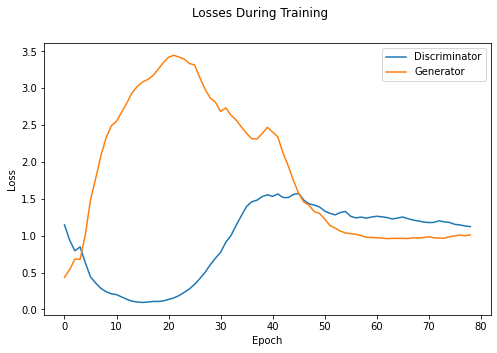

Time for epoch 79 is 1.8048579692840576 sec


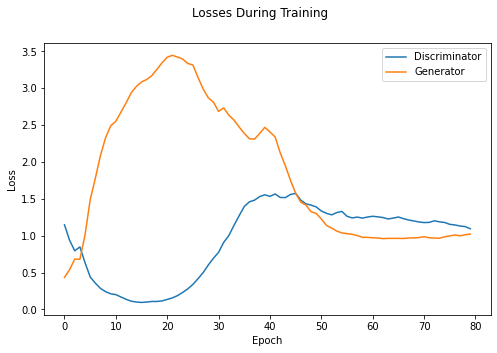

Time for epoch 80 is 3.757873773574829 sec


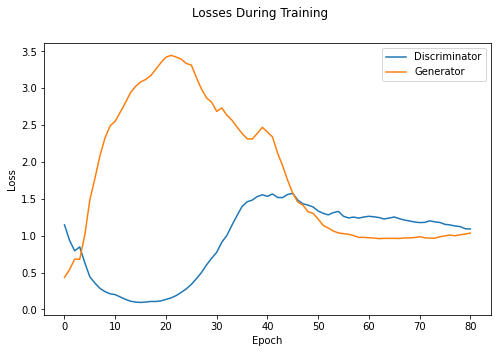

Time for epoch 81 is 1.9712705612182617 sec


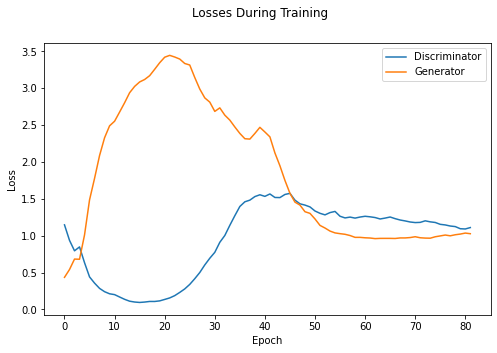

Time for epoch 82 is 1.7682735919952393 sec


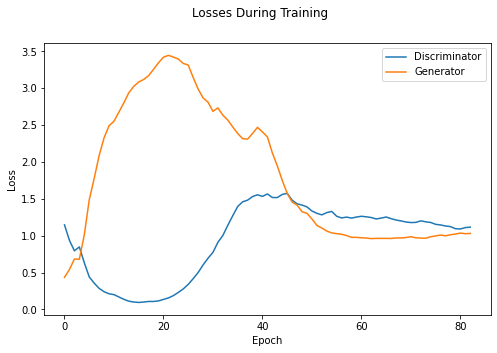

Time for epoch 83 is 1.8068184852600098 sec


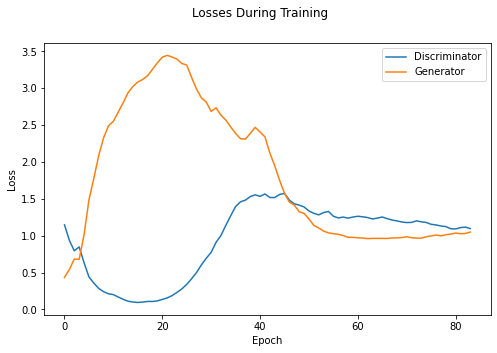

Time for epoch 84 is 1.7550299167633057 sec


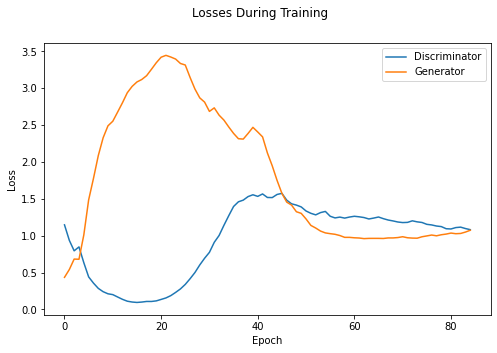

Time for epoch 85 is 2.0210518836975098 sec


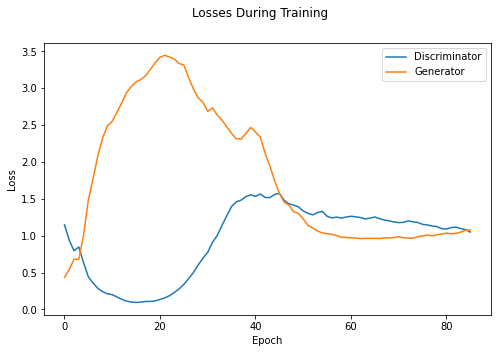

Time for epoch 86 is 3.5923404693603516 sec


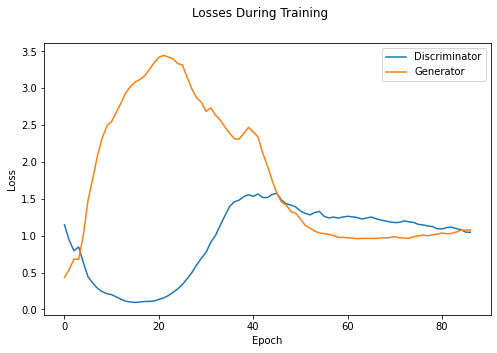

Time for epoch 87 is 2.583418607711792 sec


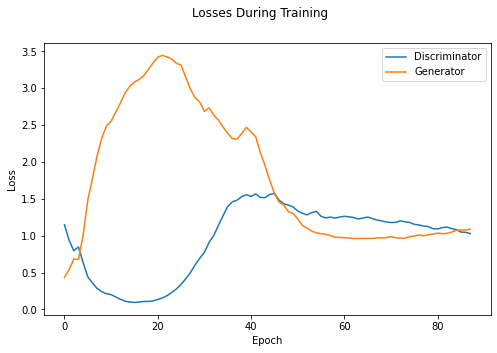

Time for epoch 88 is 1.7723309993743896 sec


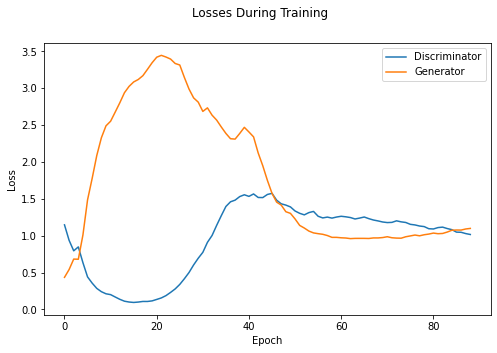

Time for epoch 89 is 1.7360436916351318 sec


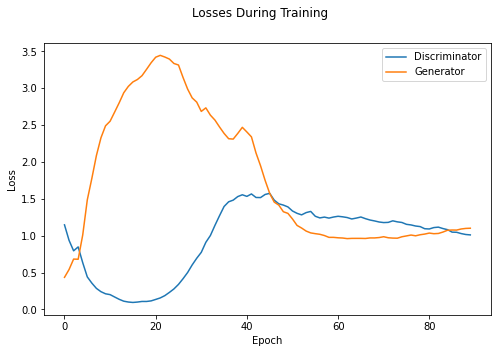

Time for epoch 90 is 1.955160140991211 sec


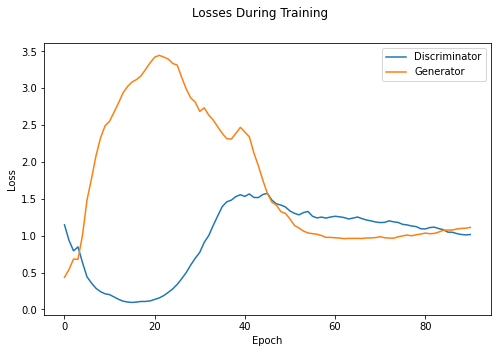

Time for epoch 91 is 1.726531982421875 sec


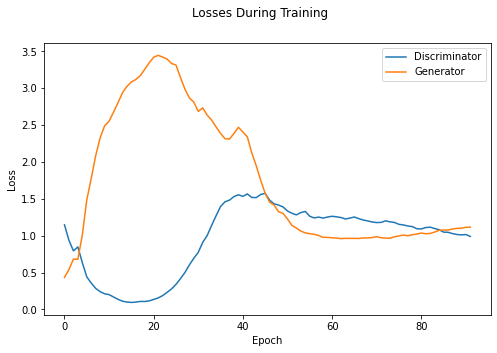

Time for epoch 92 is 1.7449538707733154 sec


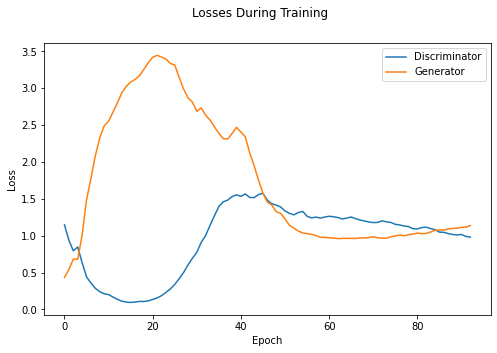

Time for epoch 93 is 1.7188851833343506 sec


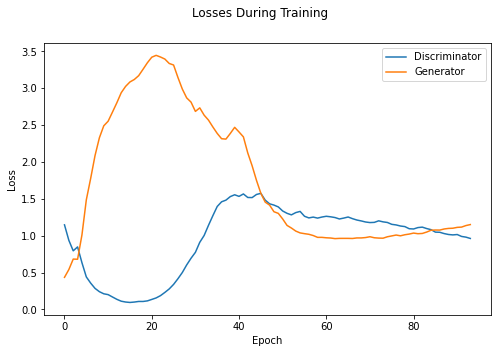

Time for epoch 94 is 1.7043042182922363 sec


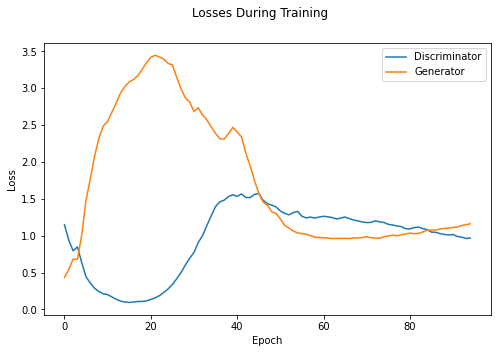

Time for epoch 95 is 1.6543450355529785 sec


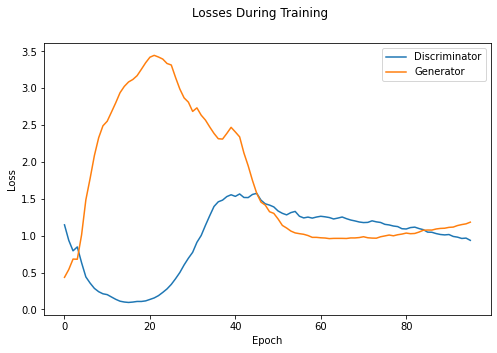

Time for epoch 96 is 1.6783430576324463 sec


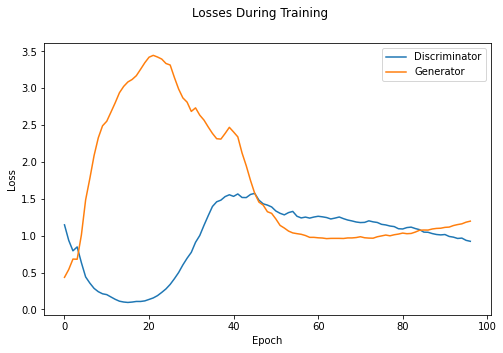

Time for epoch 97 is 1.6804893016815186 sec


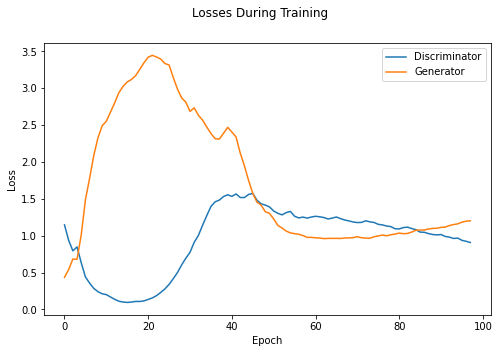

Time for epoch 98 is 3.9185638427734375 sec


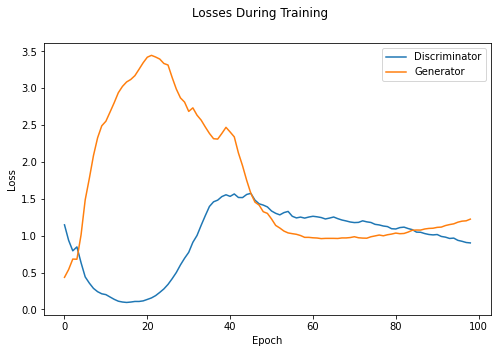

Time for epoch 99 is 2.4716527462005615 sec


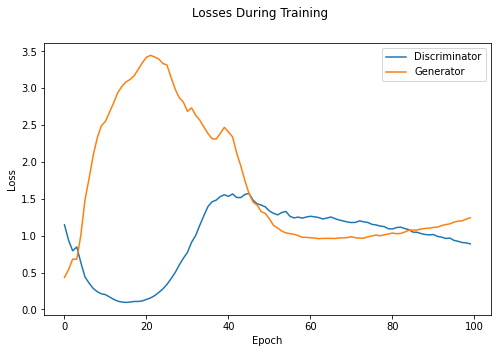

Time for epoch 100 is 1.9480254650115967 sec


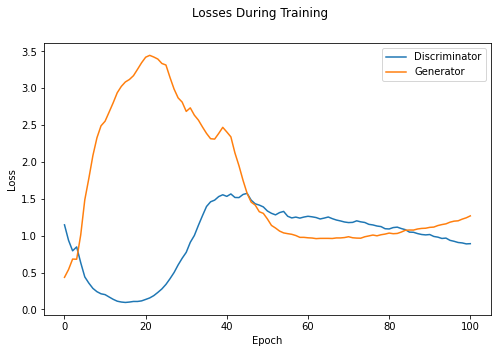

Time for epoch 101 is 1.9863860607147217 sec


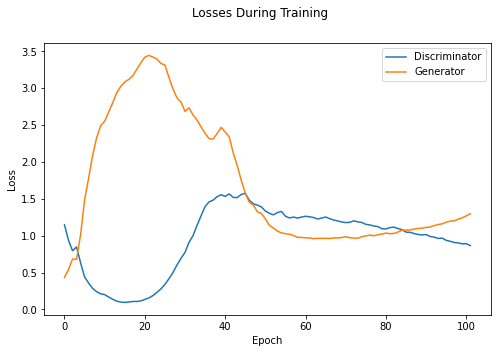

Time for epoch 102 is 1.922583818435669 sec


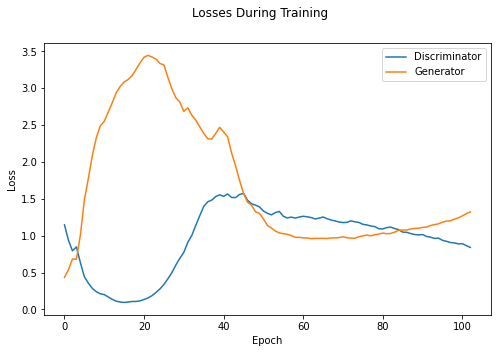

Time for epoch 103 is 2.3458187580108643 sec


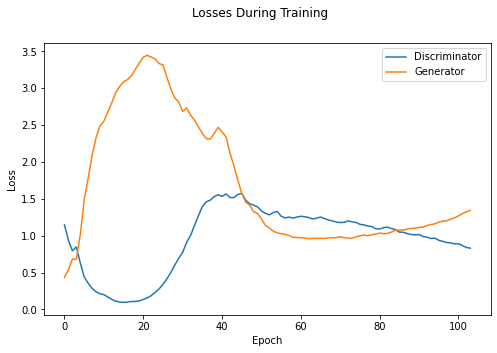

Time for epoch 104 is 3.4173550605773926 sec


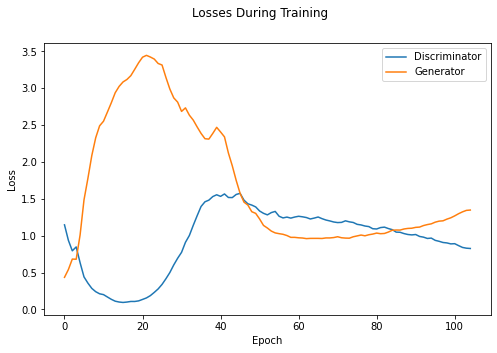

Time for epoch 105 is 1.9157648086547852 sec


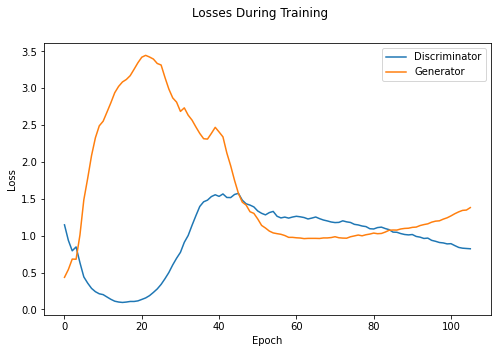

Time for epoch 106 is 1.8909969329833984 sec


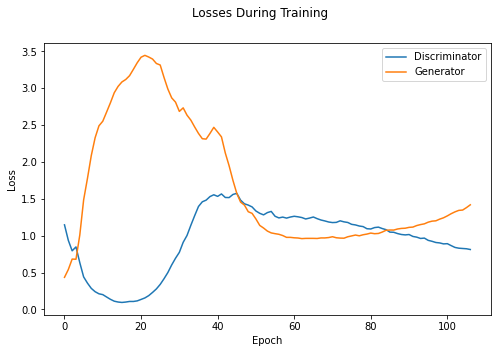

Time for epoch 107 is 1.9133448600769043 sec


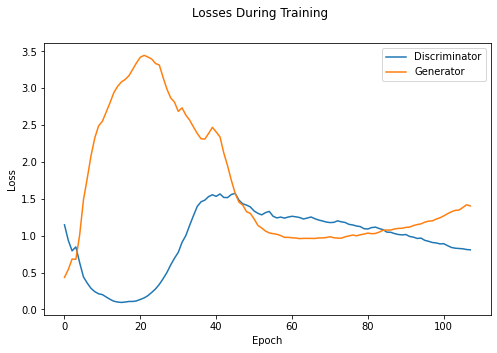

Time for epoch 108 is 1.8963189125061035 sec


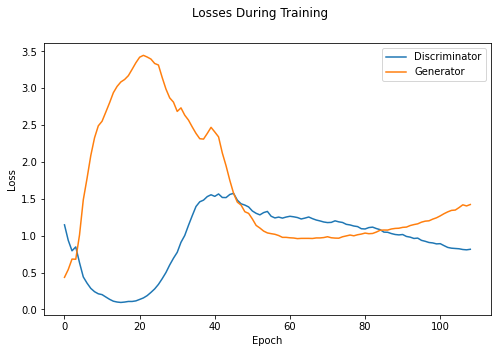

Time for epoch 109 is 1.9041380882263184 sec


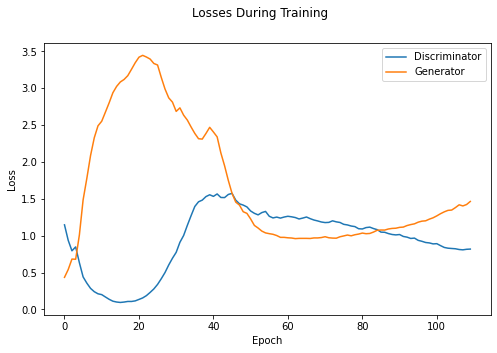

Time for epoch 110 is 1.9022865295410156 sec


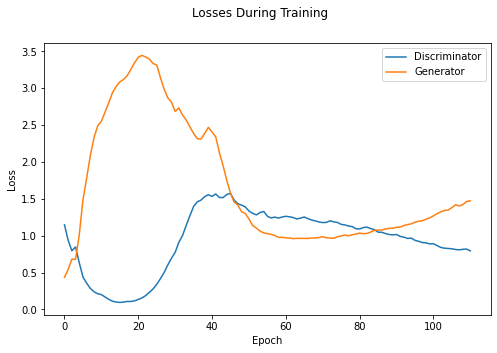

Time for epoch 111 is 1.8846216201782227 sec


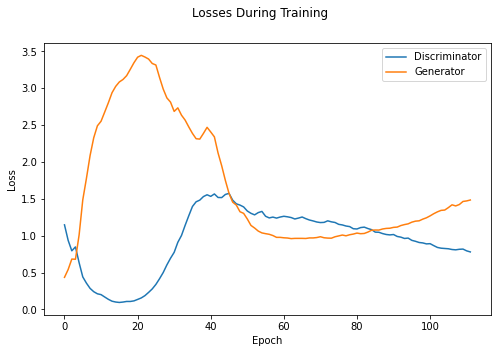

Time for epoch 112 is 1.9048380851745605 sec


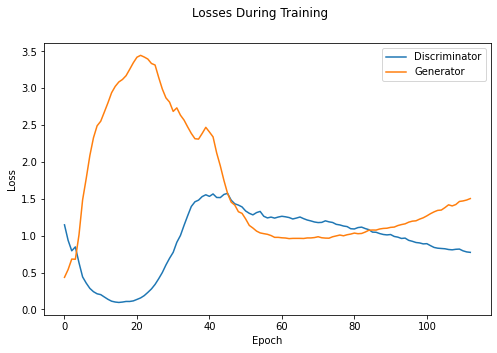

Time for epoch 113 is 1.8973548412322998 sec


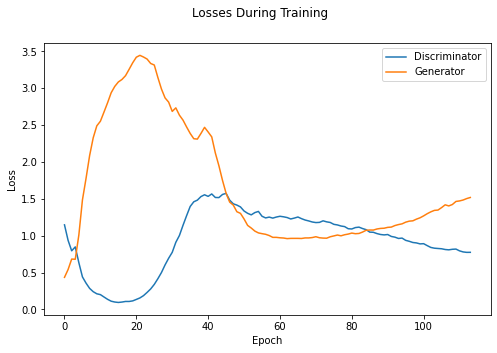

Time for epoch 114 is 2.5551416873931885 sec


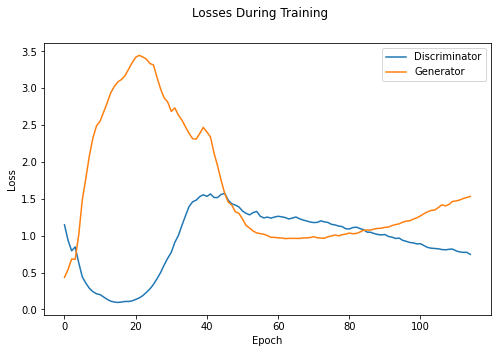

Time for epoch 115 is 1.8723797798156738 sec


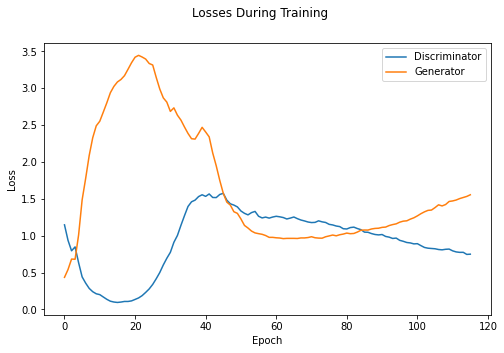

Time for epoch 116 is 1.9290716648101807 sec


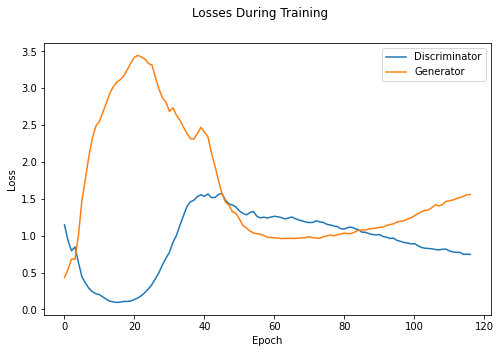

Time for epoch 117 is 2.9977529048919678 sec


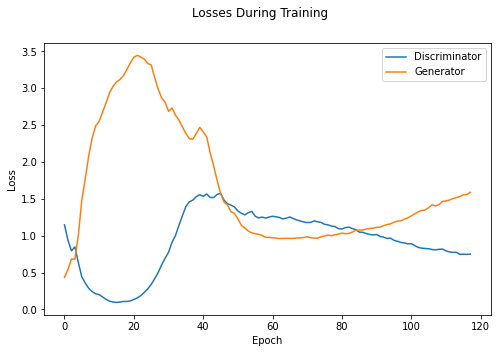

Time for epoch 118 is 1.8357574939727783 sec


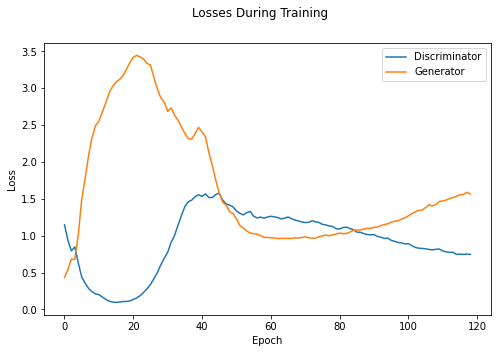

Time for epoch 119 is 3.4102985858917236 sec


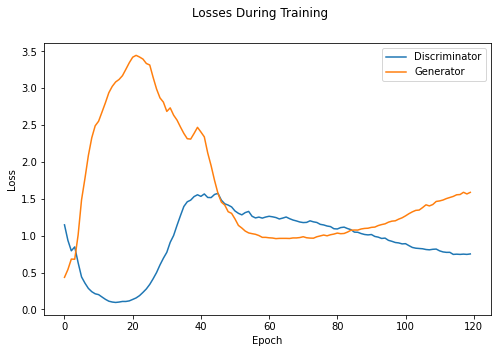

Time for epoch 120 is 1.800013542175293 sec


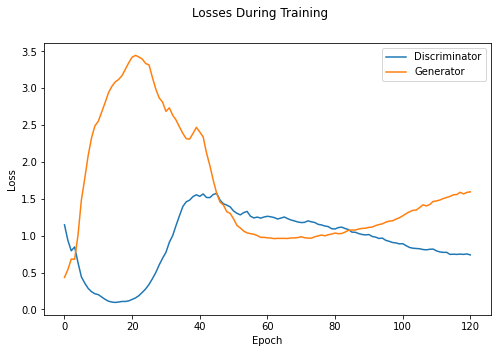

Time for epoch 121 is 1.8333251476287842 sec


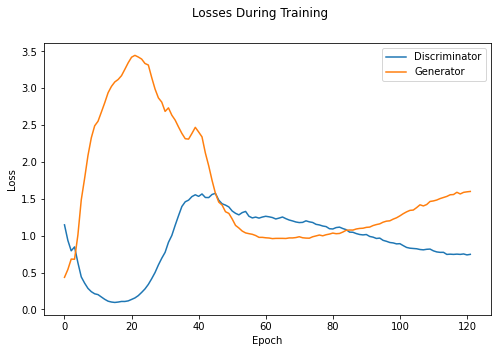

Time for epoch 122 is 1.8401765823364258 sec


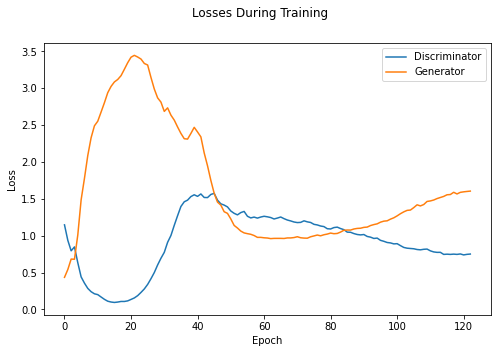

Time for epoch 123 is 1.79887056350708 sec


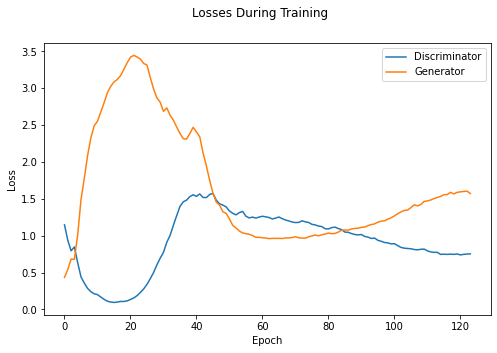

Time for epoch 124 is 1.818403720855713 sec


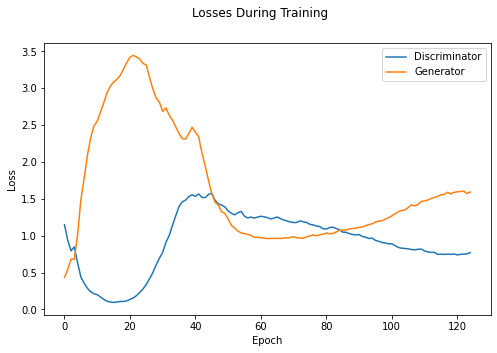

Time for epoch 125 is 1.85813570022583 sec


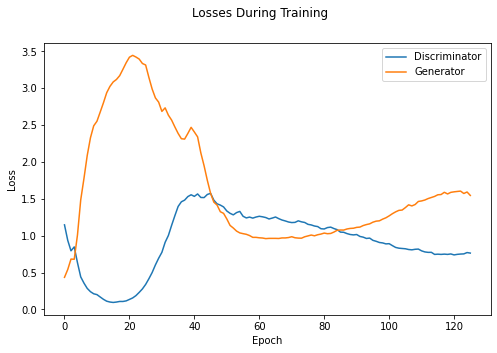

Time for epoch 126 is 1.8062307834625244 sec


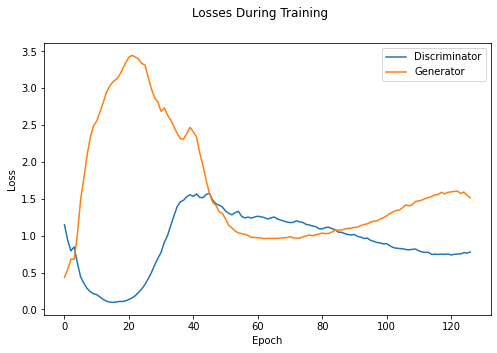

Time for epoch 127 is 1.7849435806274414 sec


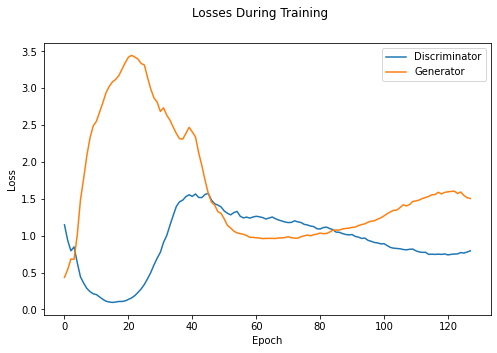

Time for epoch 128 is 2.5611324310302734 sec


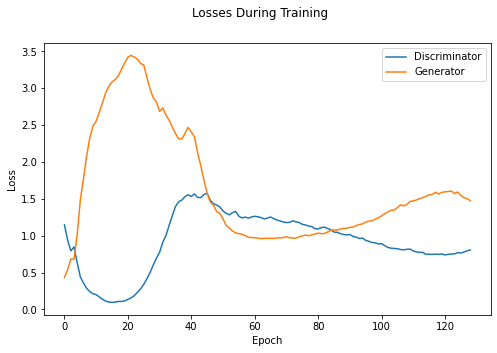

Time for epoch 129 is 3.4183483123779297 sec


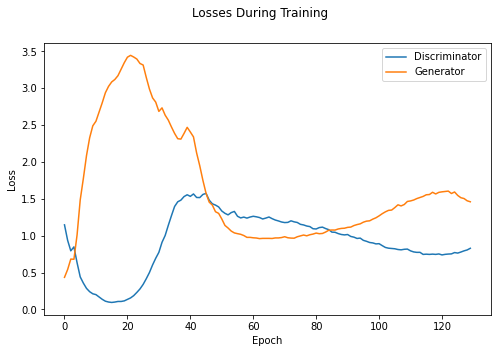

Time for epoch 130 is 1.878067970275879 sec


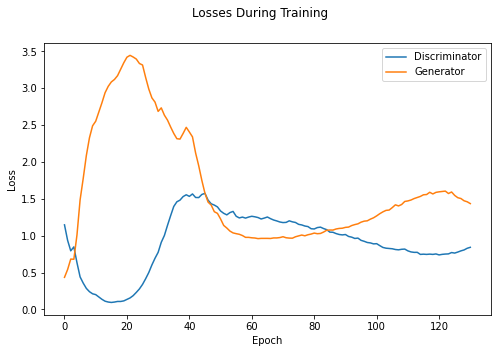

Time for epoch 131 is 1.7808513641357422 sec


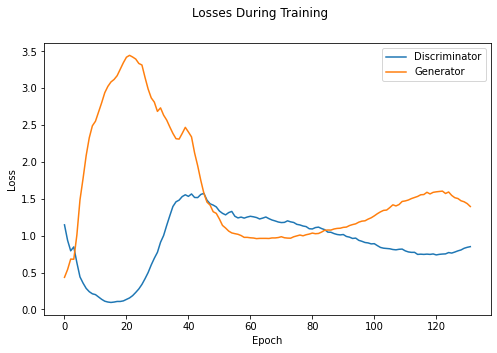

Time for epoch 132 is 1.770505428314209 sec


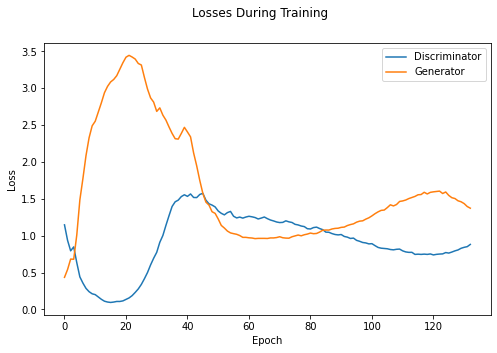

Time for epoch 133 is 1.734433650970459 sec


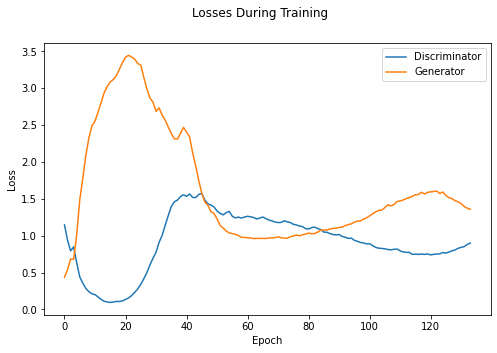

Time for epoch 134 is 1.7294418811798096 sec


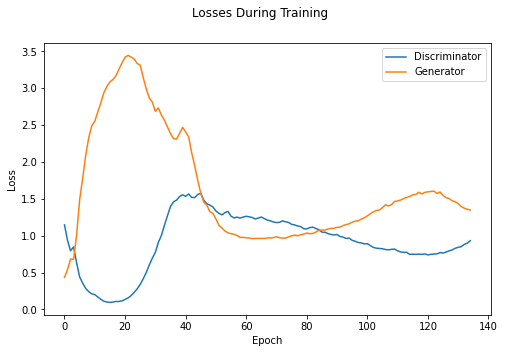

Time for epoch 135 is 1.801323652267456 sec


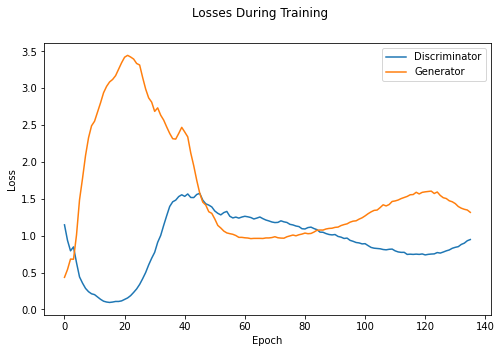

Time for epoch 136 is 2.1568663120269775 sec


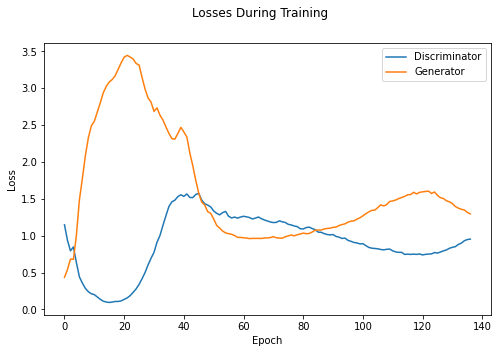

Time for epoch 137 is 3.6069791316986084 sec


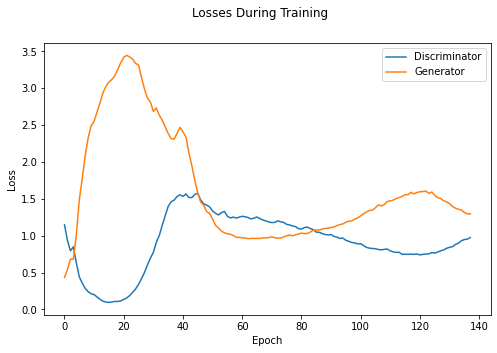

Time for epoch 138 is 1.7234857082366943 sec


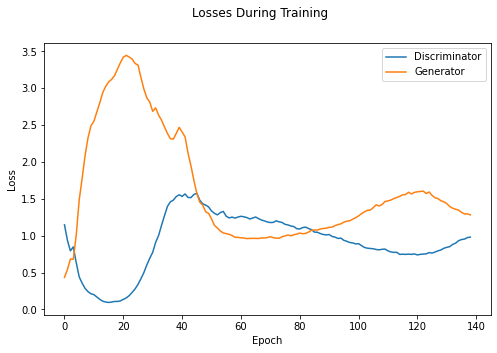

Time for epoch 139 is 2.5140185356140137 sec


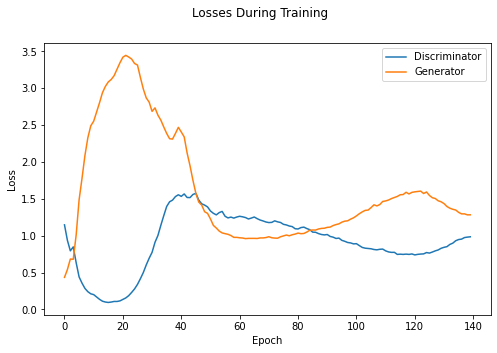

Time for epoch 140 is 1.7727715969085693 sec


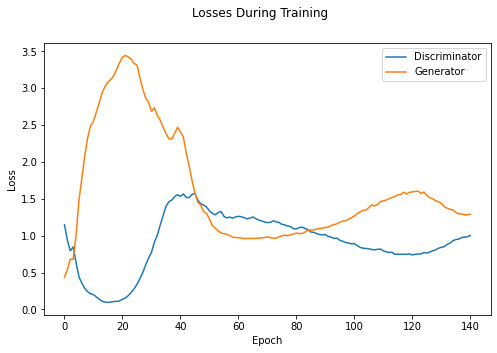

Time for epoch 141 is 3.5104176998138428 sec


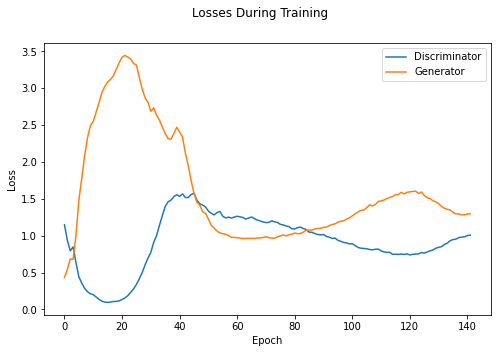

Time for epoch 142 is 1.7015559673309326 sec


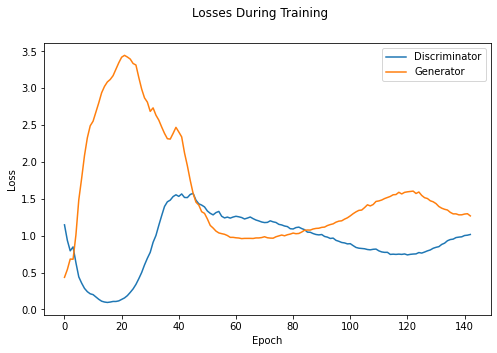

Time for epoch 143 is 1.7109324932098389 sec


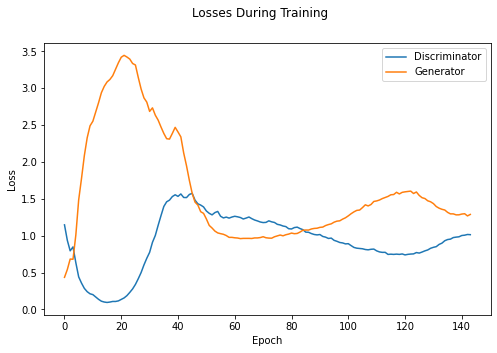

Time for epoch 144 is 1.692347526550293 sec


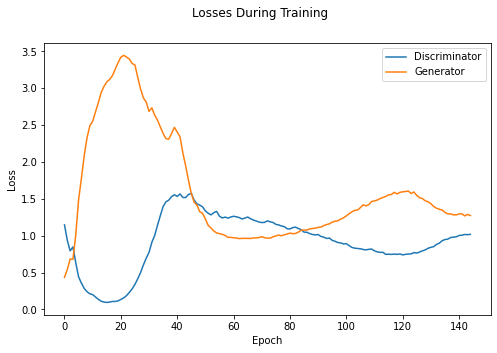

Time for epoch 145 is 1.7042577266693115 sec


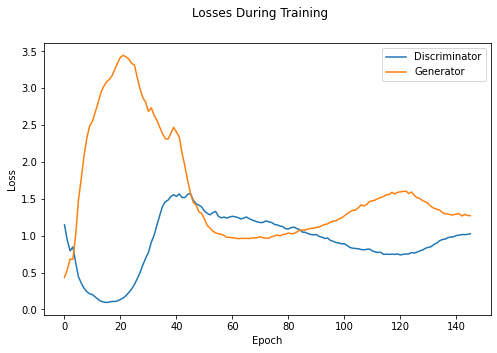

Time for epoch 146 is 2.267906904220581 sec


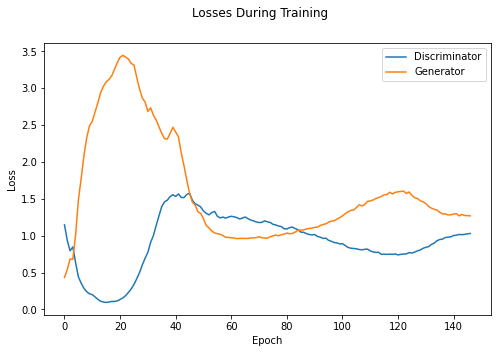

Time for epoch 147 is 3.1172804832458496 sec


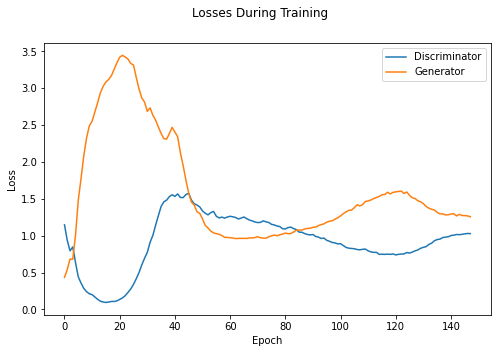

Time for epoch 148 is 1.9559593200683594 sec


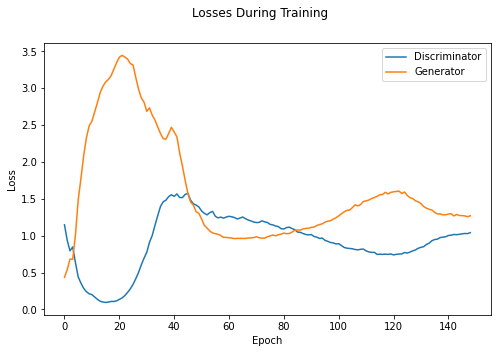

Time for epoch 149 is 1.9481134414672852 sec


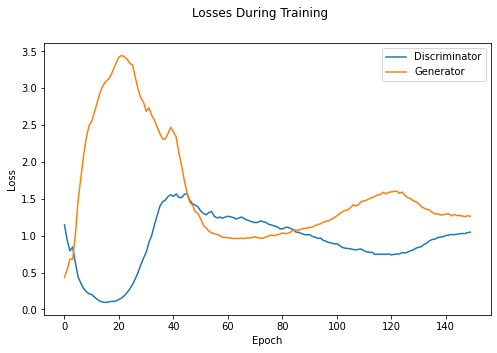

Time for epoch 150 is 1.9567570686340332 sec


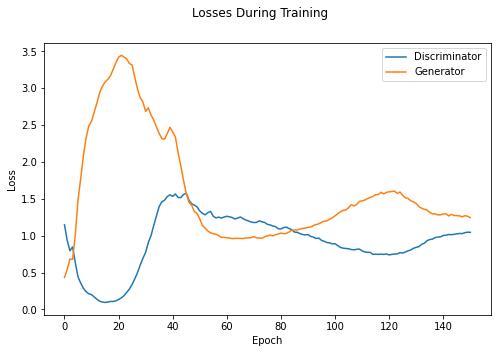

Time for epoch 151 is 1.9277338981628418 sec


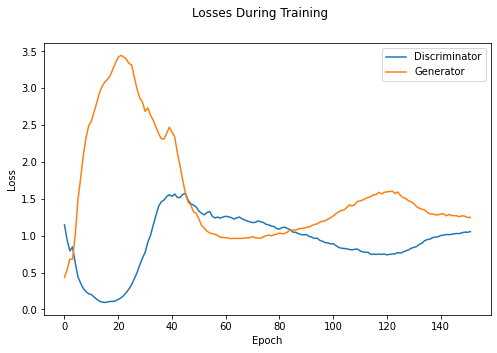

Time for epoch 152 is 1.917853832244873 sec


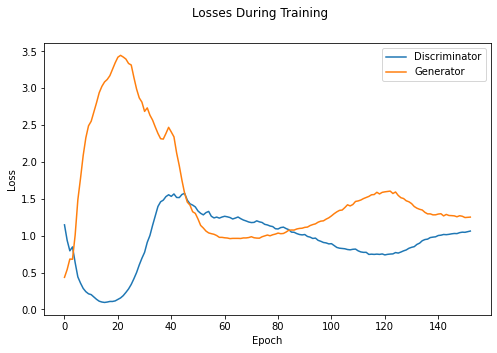

Time for epoch 153 is 1.9327847957611084 sec


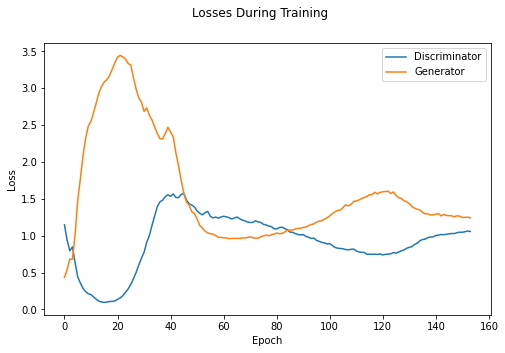

Time for epoch 154 is 1.9561190605163574 sec


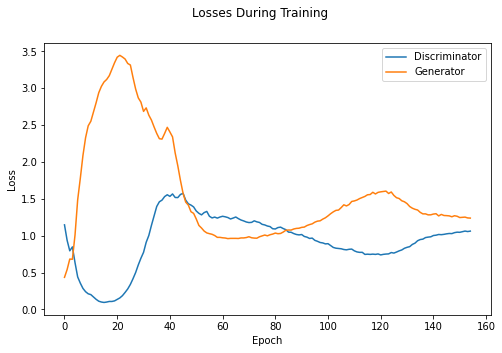

Time for epoch 155 is 1.9483540058135986 sec


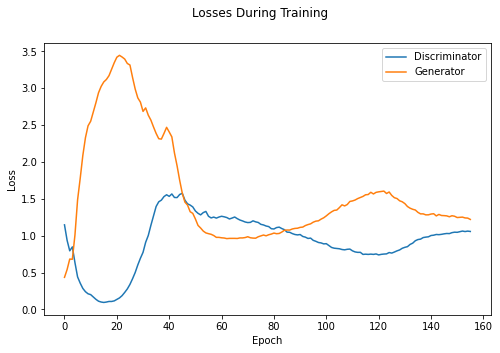

Time for epoch 156 is 2.337972640991211 sec


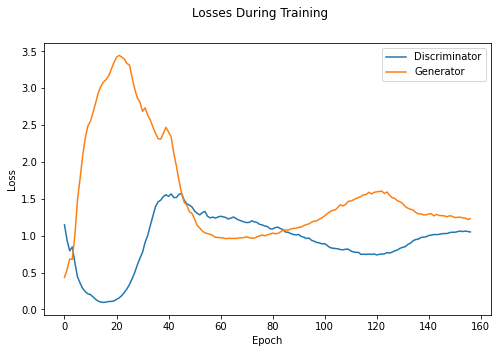

Time for epoch 157 is 1.8498222827911377 sec


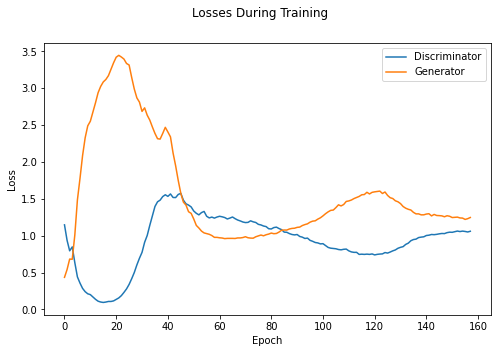

Time for epoch 158 is 1.906808614730835 sec


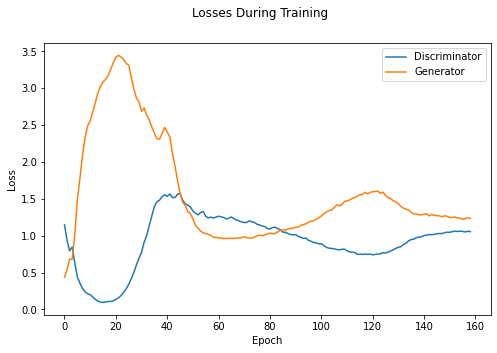

Time for epoch 159 is 3.467360258102417 sec


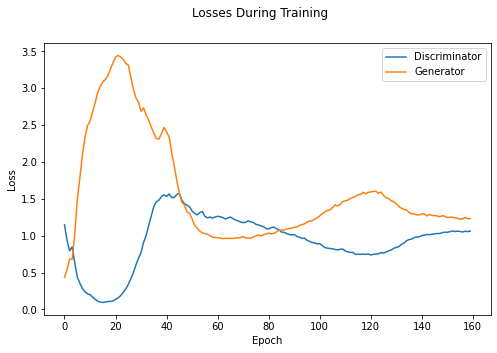

Time for epoch 160 is 1.9630682468414307 sec


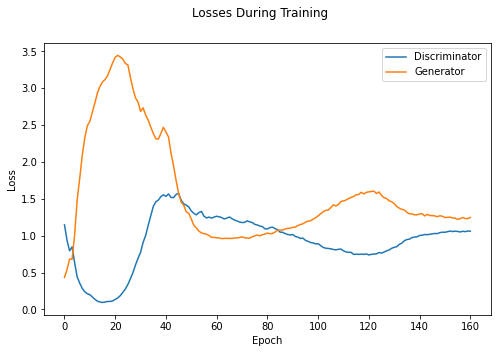

Time for epoch 161 is 1.9014391899108887 sec


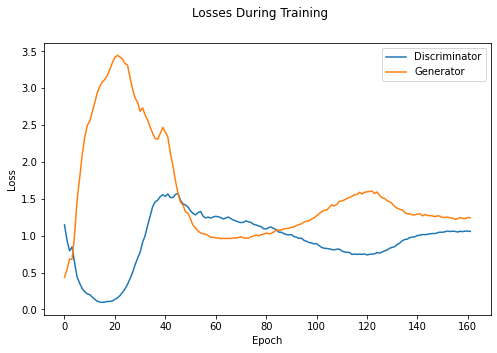

Time for epoch 162 is 1.8257925510406494 sec


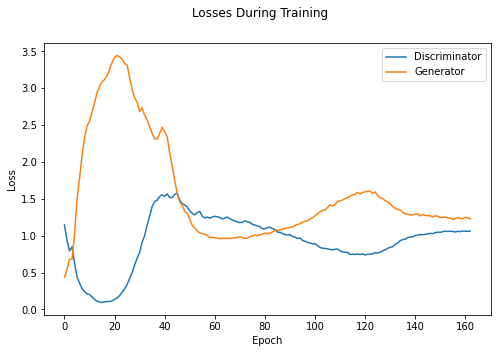

Time for epoch 163 is 1.8769629001617432 sec


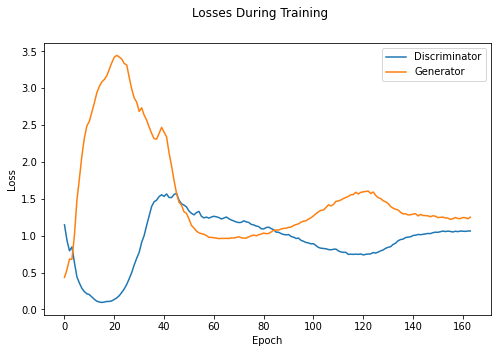

Time for epoch 164 is 1.8348379135131836 sec


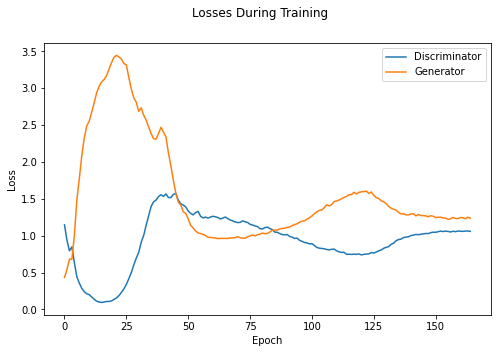

Time for epoch 165 is 1.8474624156951904 sec


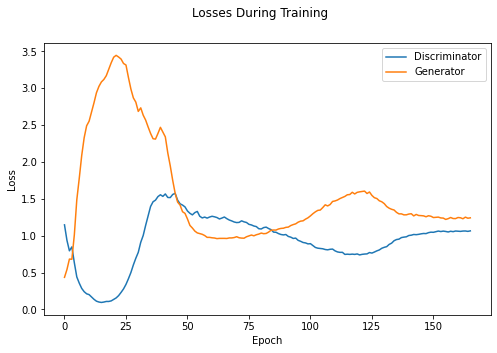

Time for epoch 166 is 1.888310432434082 sec


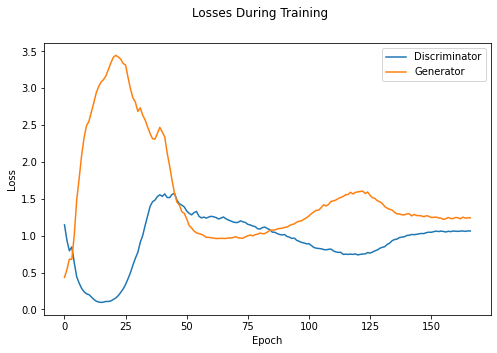

Time for epoch 167 is 1.8280410766601562 sec


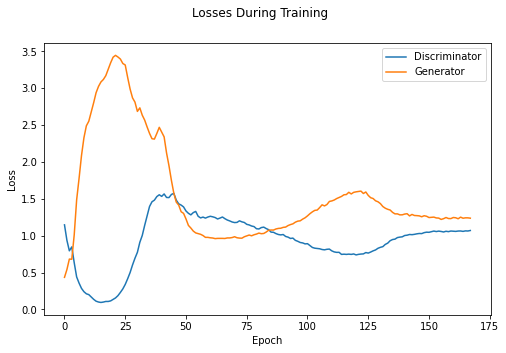

Time for epoch 168 is 1.833869218826294 sec


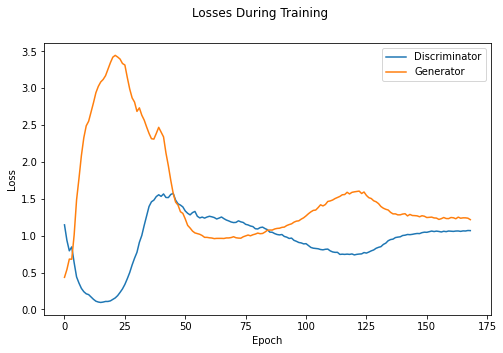

Time for epoch 169 is 1.8332431316375732 sec


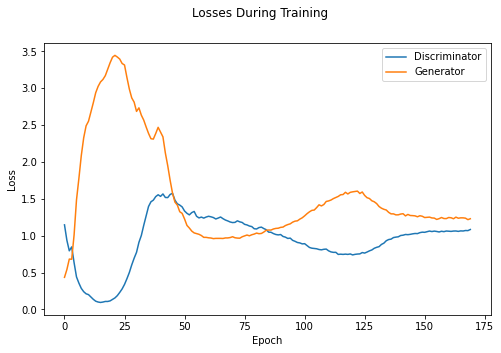

Time for epoch 170 is 2.721611261367798 sec


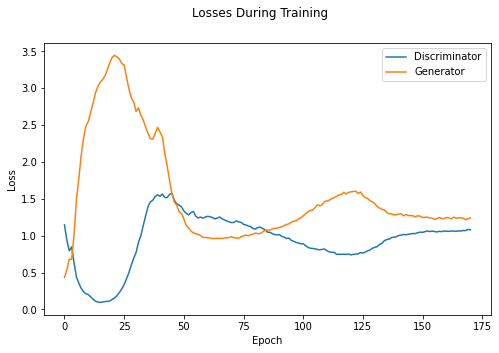

Time for epoch 171 is 2.7063605785369873 sec


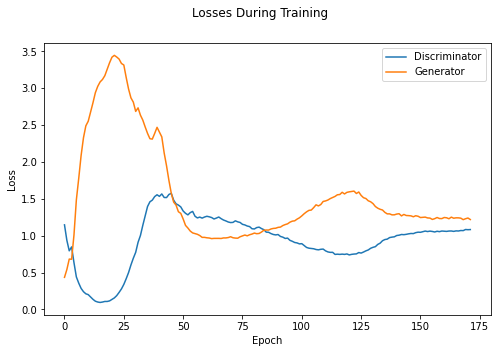

Time for epoch 172 is 1.8235573768615723 sec


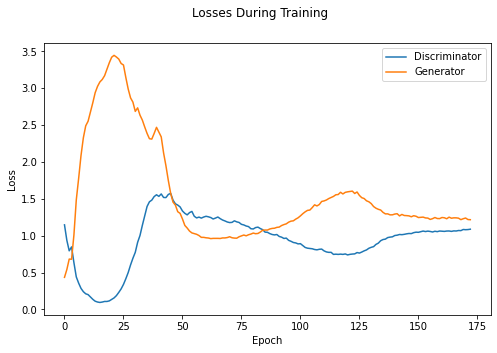

Time for epoch 173 is 1.7935891151428223 sec


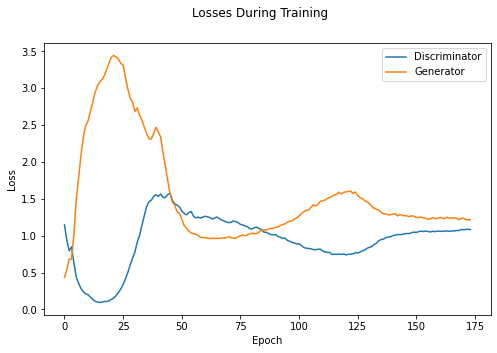

Time for epoch 174 is 3.030421495437622 sec


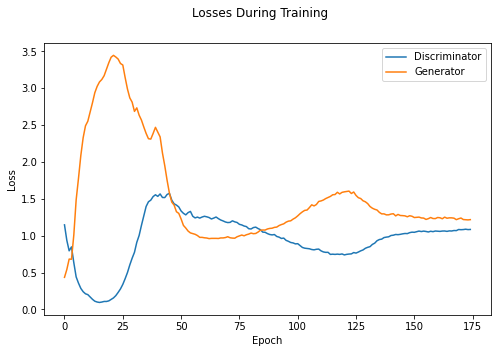

Time for epoch 175 is 3.054248809814453 sec


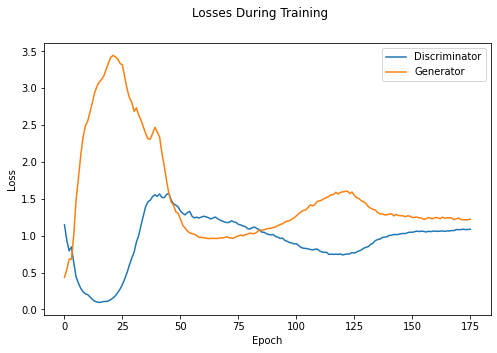

Time for epoch 176 is 2.624953508377075 sec


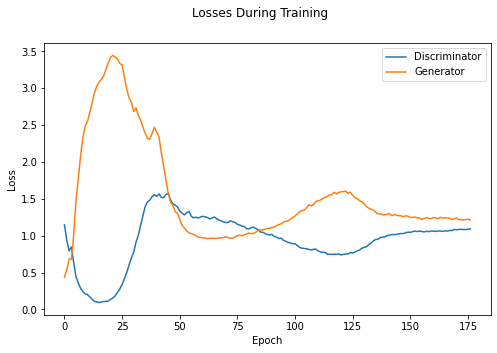

Time for epoch 177 is 1.7940645217895508 sec


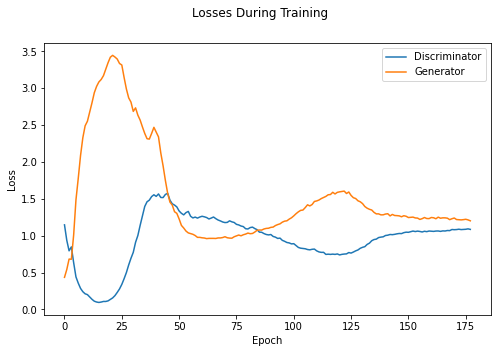

Time for epoch 178 is 1.8019754886627197 sec


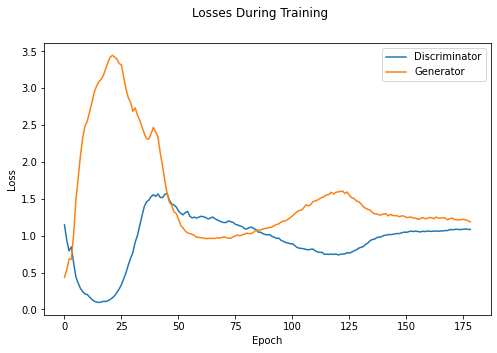

Time for epoch 179 is 3.8711986541748047 sec


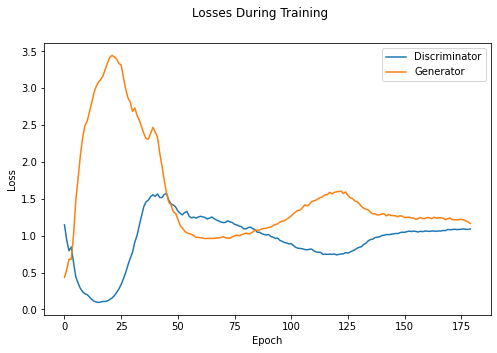

Time for epoch 180 is 1.759427785873413 sec


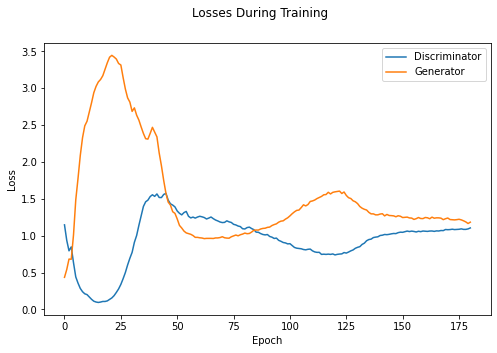

Time for epoch 181 is 1.7423961162567139 sec


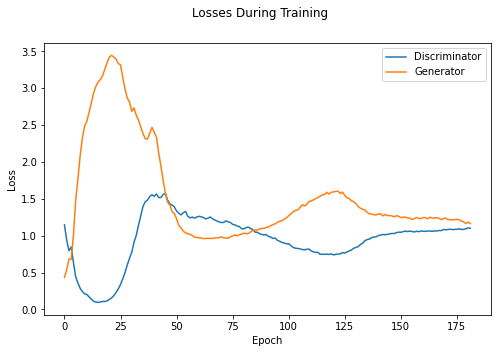

Time for epoch 182 is 3.537014961242676 sec


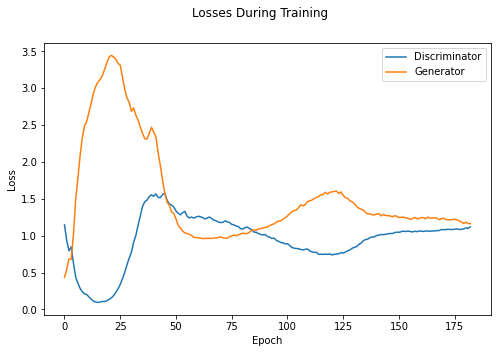

Time for epoch 183 is 1.7960472106933594 sec


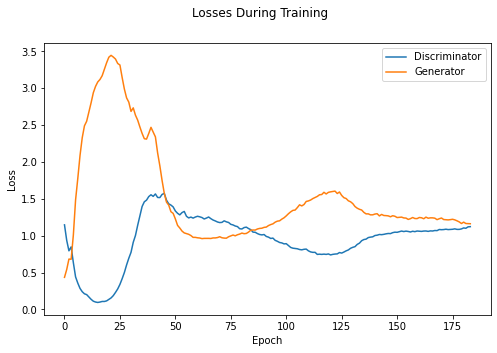

Time for epoch 184 is 2.5028841495513916 sec


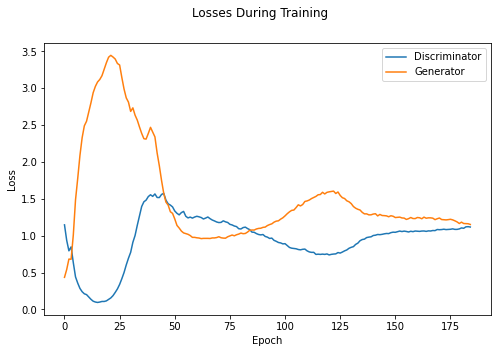

Time for epoch 185 is 1.7522270679473877 sec


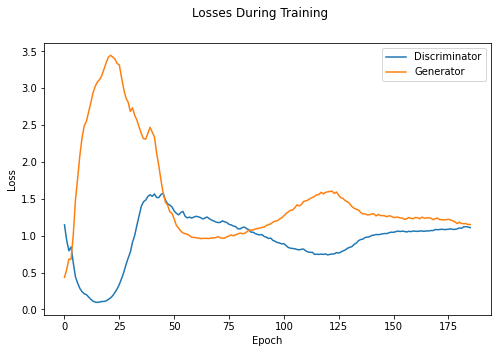

Time for epoch 186 is 1.746354341506958 sec


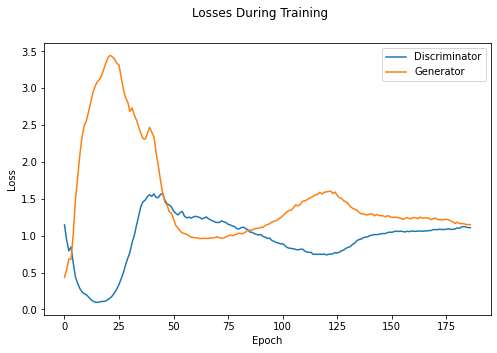

Time for epoch 187 is 1.7260324954986572 sec


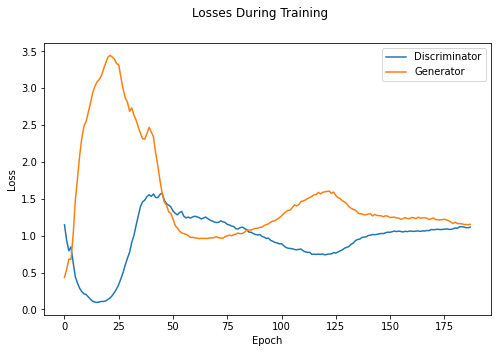

Time for epoch 188 is 1.7872331142425537 sec


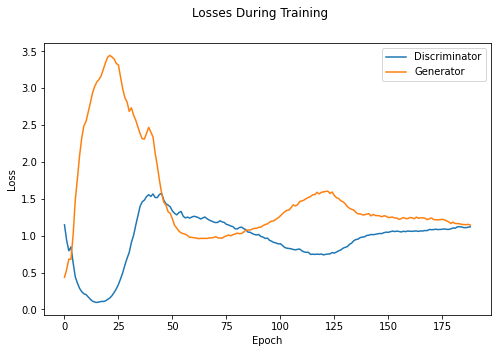

Time for epoch 189 is 1.7009782791137695 sec


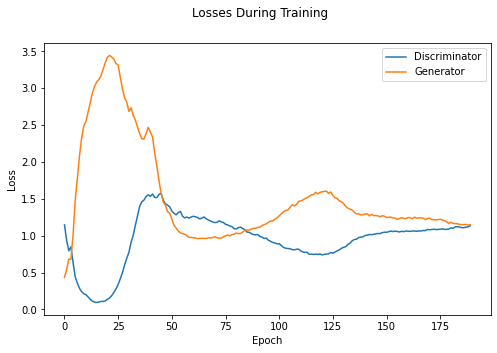

Time for epoch 190 is 1.7372033596038818 sec


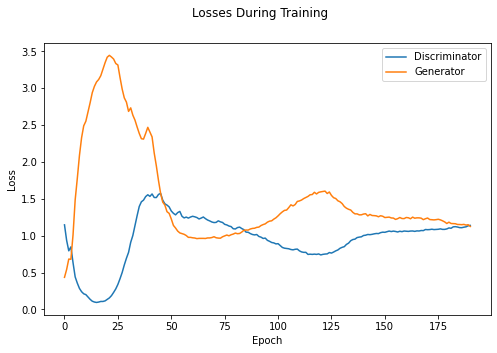

Time for epoch 191 is 1.7121319770812988 sec


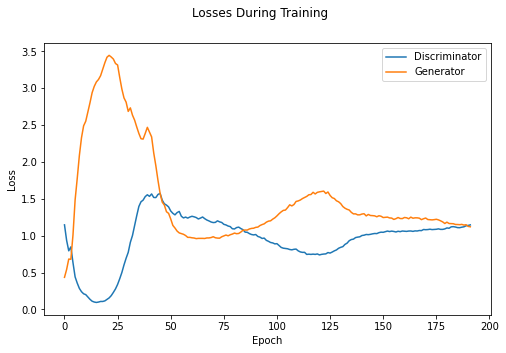

Time for epoch 192 is 1.7742021083831787 sec


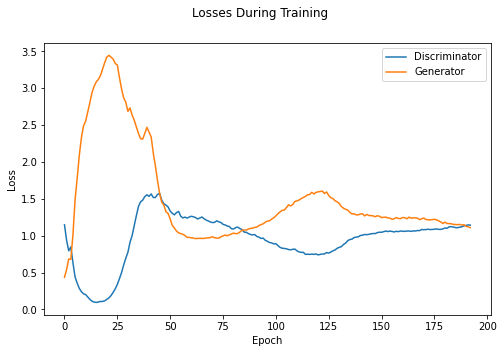

Time for epoch 193 is 2.6753318309783936 sec


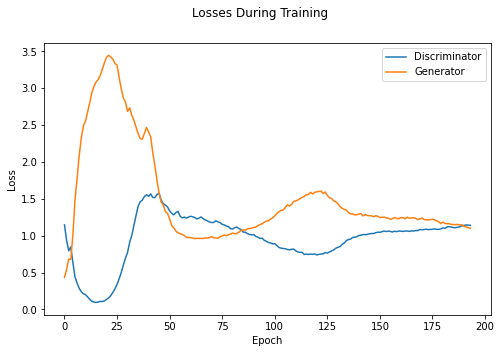

Time for epoch 194 is 1.952805757522583 sec


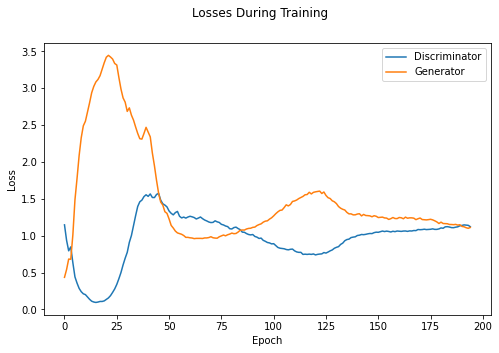

Time for epoch 195 is 1.9832987785339355 sec


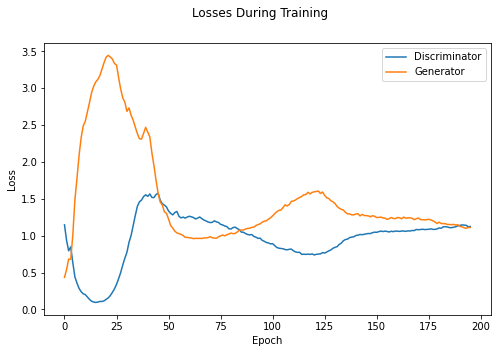

Time for epoch 196 is 4.234518766403198 sec


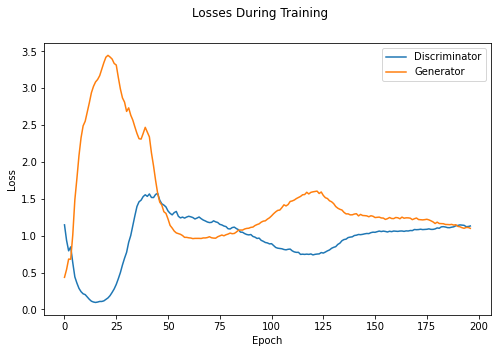

Time for epoch 197 is 1.9376330375671387 sec


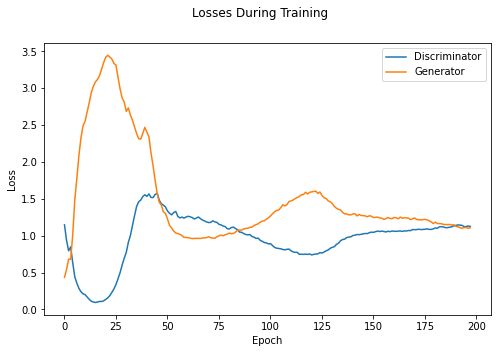

Time for epoch 198 is 3.748217821121216 sec


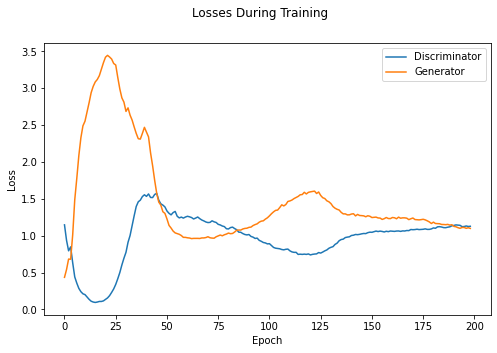

Time for epoch 199 is 1.9237122535705566 sec


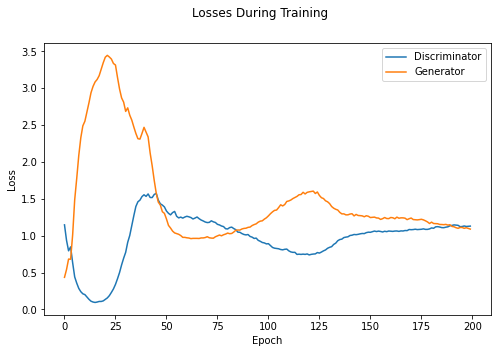

Time for epoch 200 is 1.9125308990478516 sec


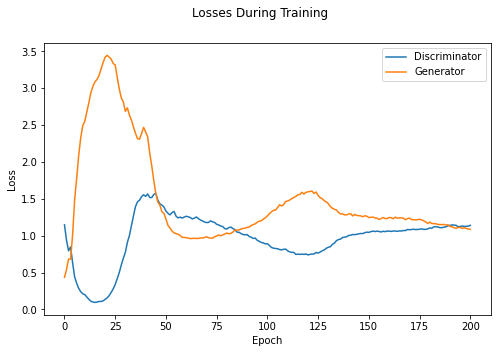

Time for epoch 201 is 2.574073314666748 sec


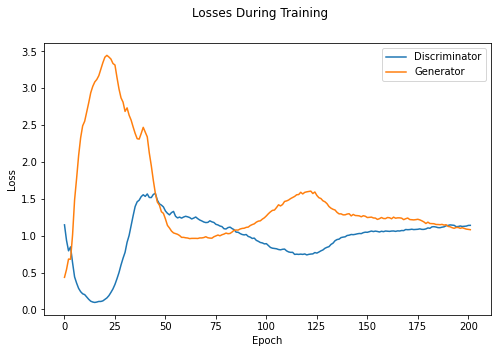

Time for epoch 202 is 1.883965015411377 sec


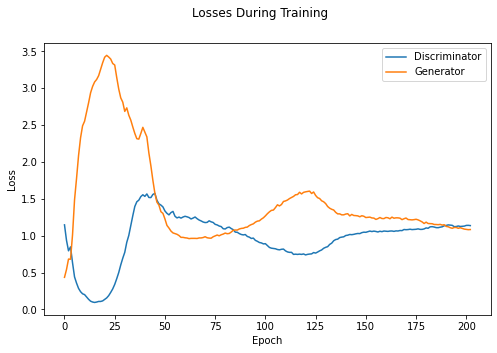

Time for epoch 203 is 1.8871123790740967 sec


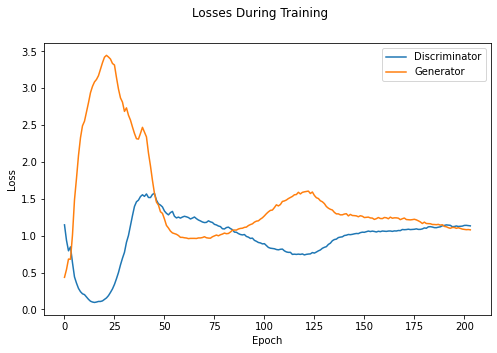

Time for epoch 204 is 1.882239818572998 sec


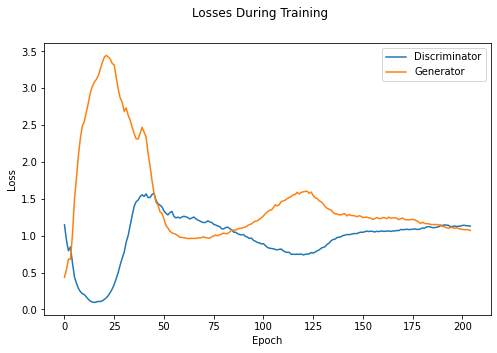

Time for epoch 205 is 1.8818652629852295 sec


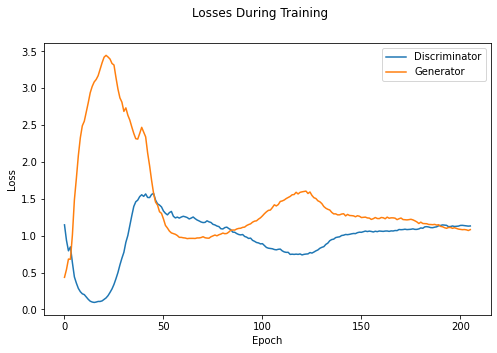

Time for epoch 206 is 1.8465590476989746 sec


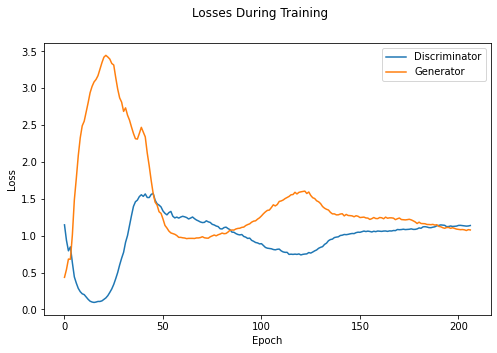

Time for epoch 207 is 1.864767074584961 sec


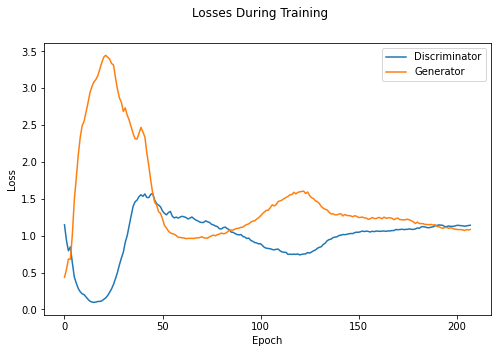

Time for epoch 208 is 1.8624236583709717 sec


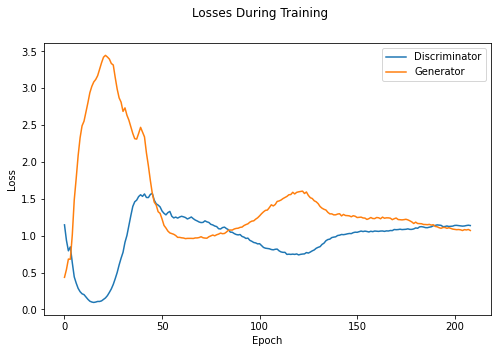

Time for epoch 209 is 4.104810953140259 sec


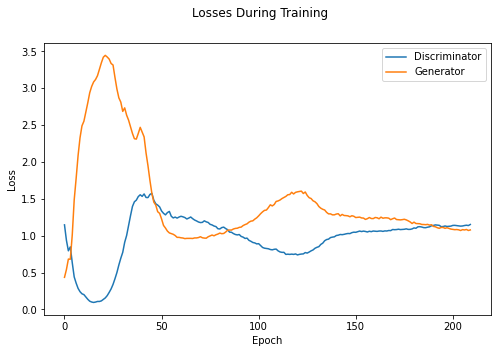

Time for epoch 210 is 1.864438772201538 sec


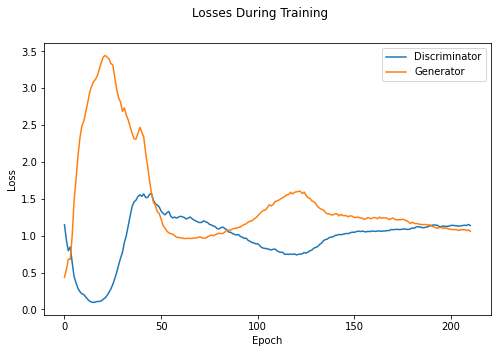

Time for epoch 211 is 1.8306732177734375 sec


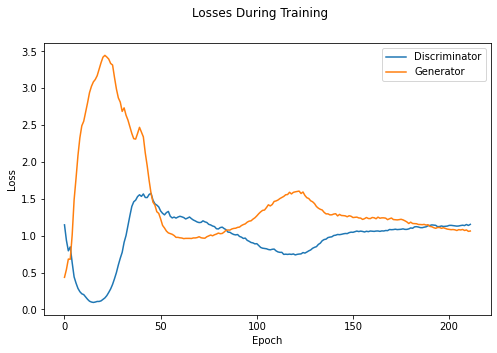

Time for epoch 212 is 1.827153205871582 sec


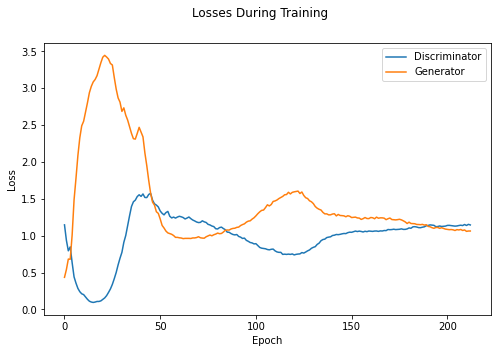

Time for epoch 213 is 1.8321914672851562 sec


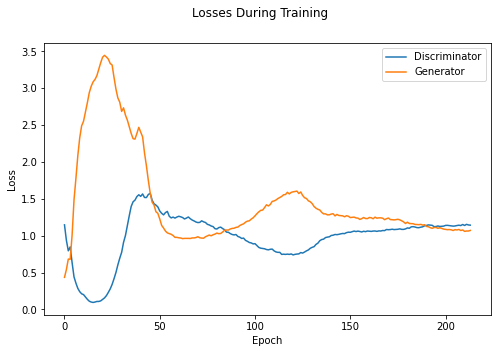

Time for epoch 214 is 1.8307600021362305 sec


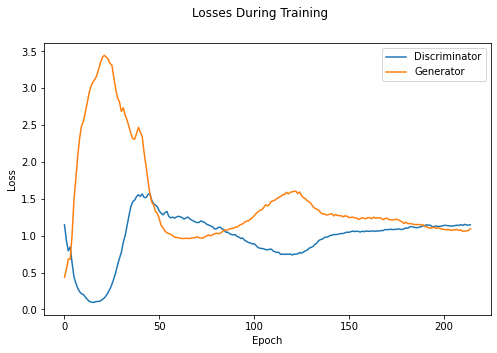

Time for epoch 215 is 1.860703945159912 sec


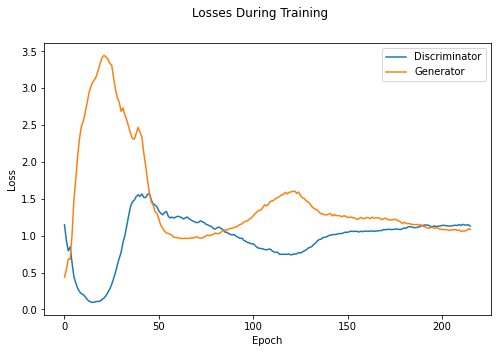

Time for epoch 216 is 1.814560890197754 sec


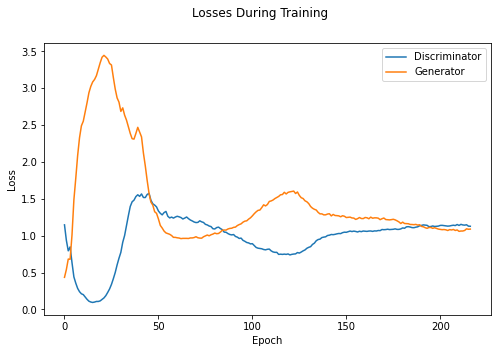

Time for epoch 217 is 4.0739052295684814 sec


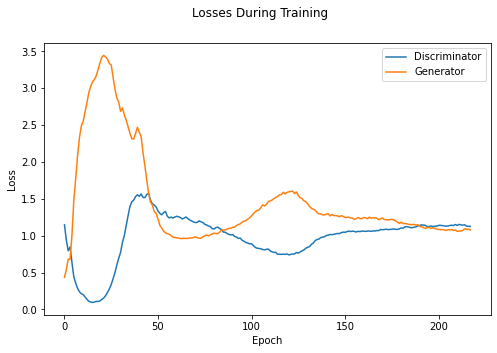

Time for epoch 218 is 1.83329176902771 sec


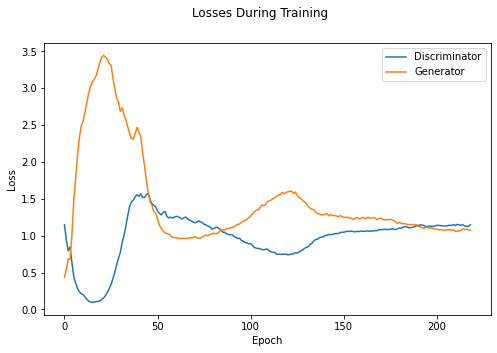

Time for epoch 219 is 1.799854040145874 sec


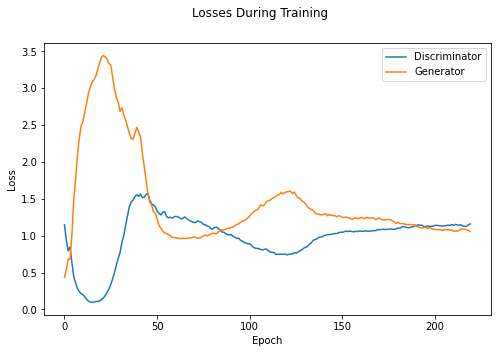

Time for epoch 220 is 1.794240951538086 sec


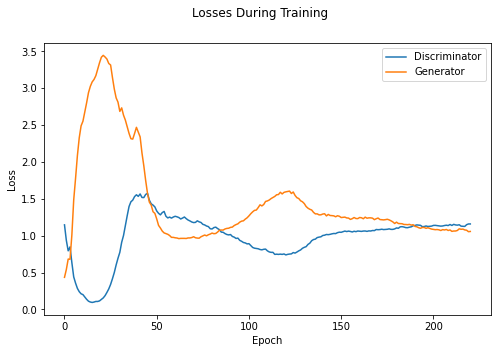

Time for epoch 221 is 1.7933320999145508 sec


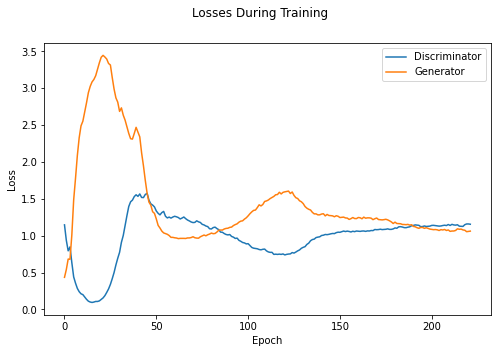

Time for epoch 222 is 1.7735605239868164 sec


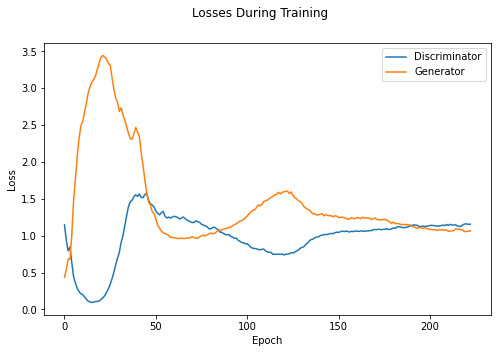

Time for epoch 223 is 1.7813091278076172 sec


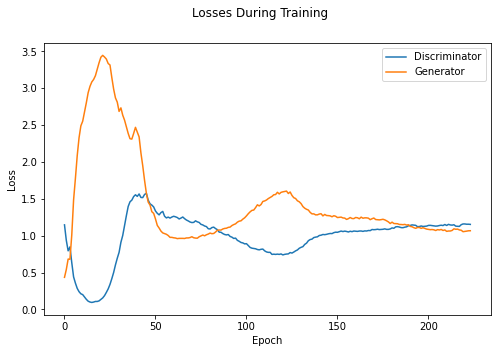

Time for epoch 224 is 1.840987205505371 sec


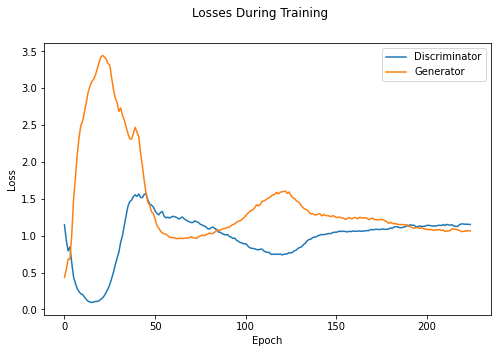

Time for epoch 225 is 1.7796127796173096 sec


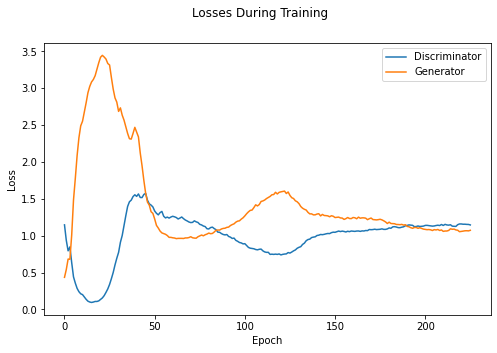

Time for epoch 226 is 3.4541940689086914 sec


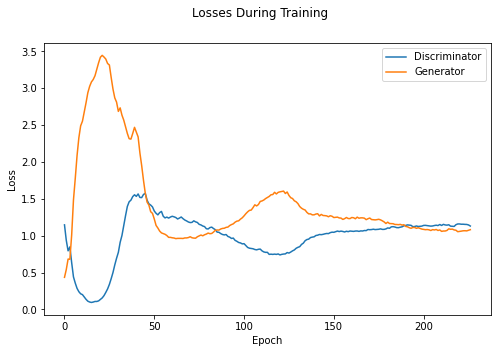

Time for epoch 227 is 1.7688302993774414 sec


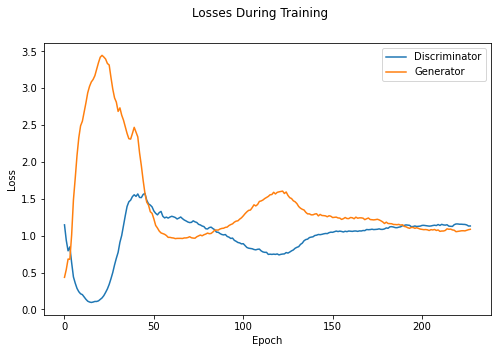

Time for epoch 228 is 1.8013296127319336 sec


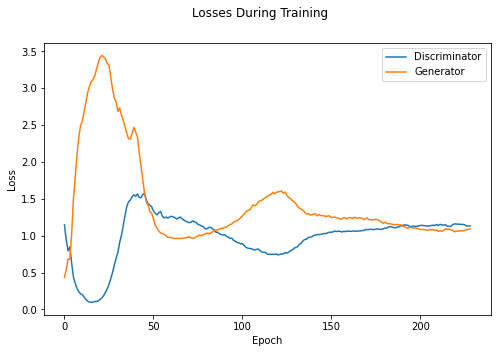

Time for epoch 229 is 3.0181081295013428 sec


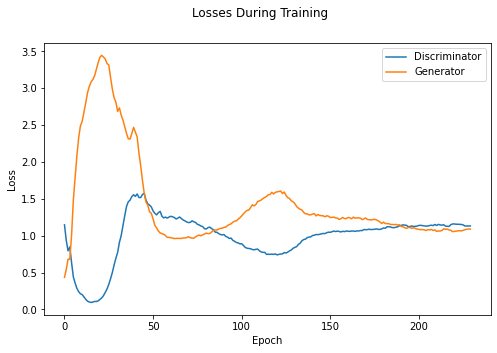

Time for epoch 230 is 3.368483304977417 sec


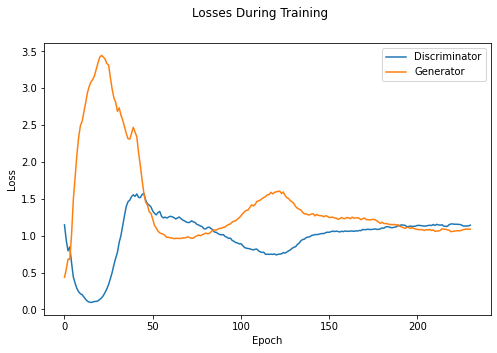

Time for epoch 231 is 1.740393877029419 sec


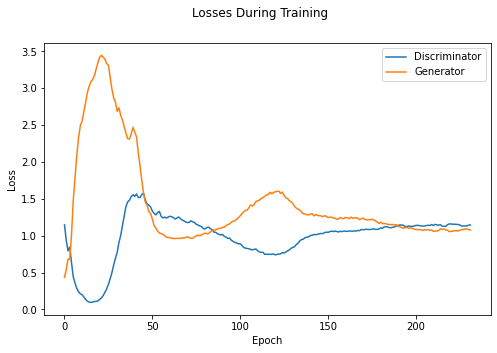

Time for epoch 232 is 3.1592025756835938 sec


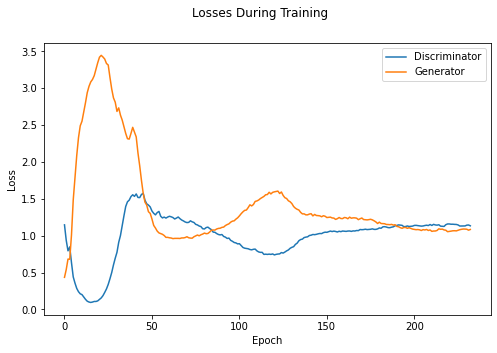

Time for epoch 233 is 1.7491579055786133 sec


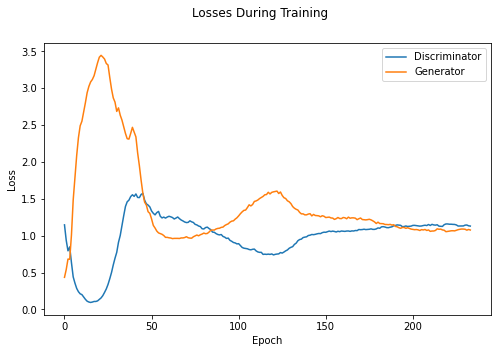

Time for epoch 234 is 3.581179141998291 sec


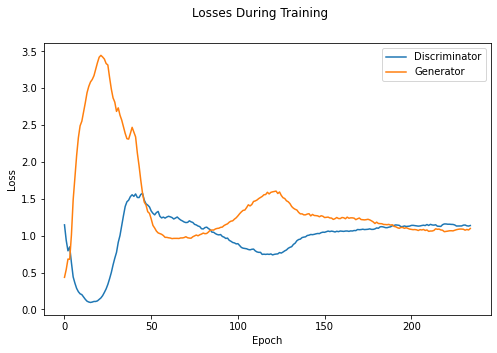

Time for epoch 235 is 1.7489104270935059 sec


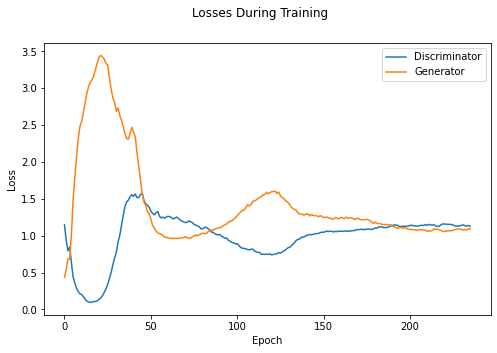

Time for epoch 236 is 1.7100014686584473 sec


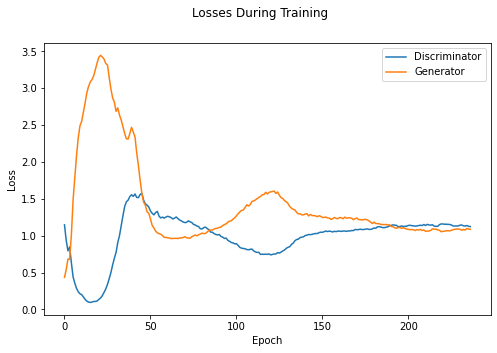

Time for epoch 237 is 1.7404139041900635 sec


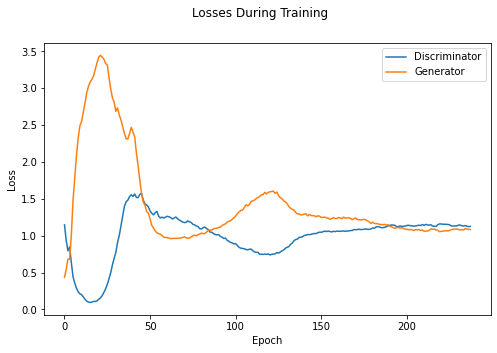

Time for epoch 238 is 1.6817853450775146 sec


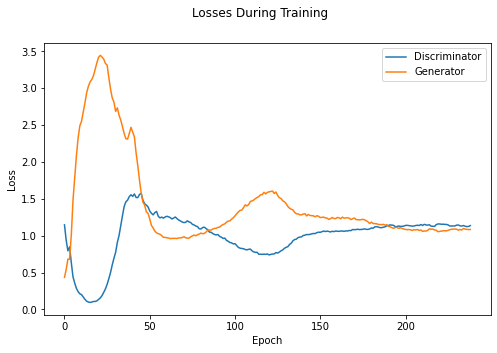

Time for epoch 239 is 2.746396780014038 sec


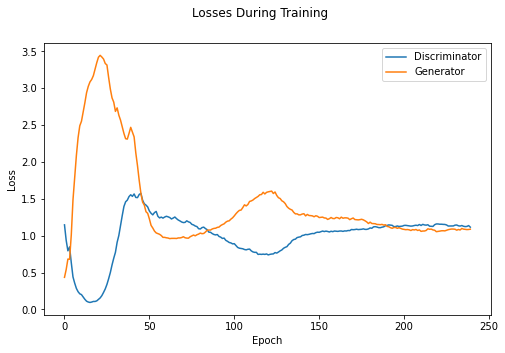

Time for epoch 240 is 1.663450002670288 sec


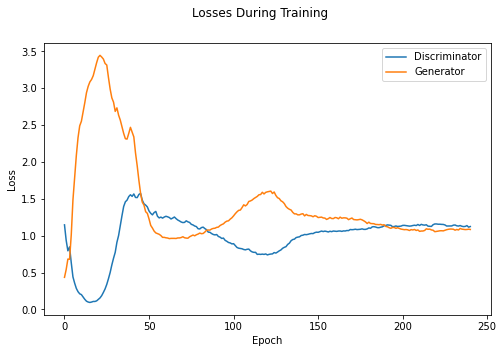

Time for epoch 241 is 2.4029905796051025 sec


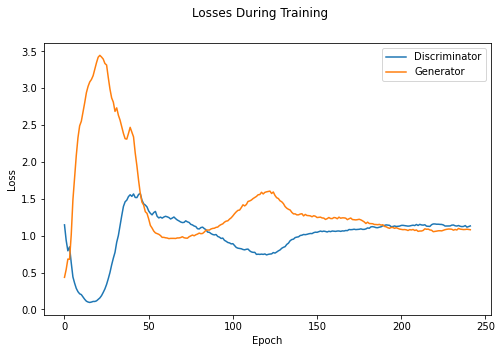

Time for epoch 242 is 3.6283366680145264 sec


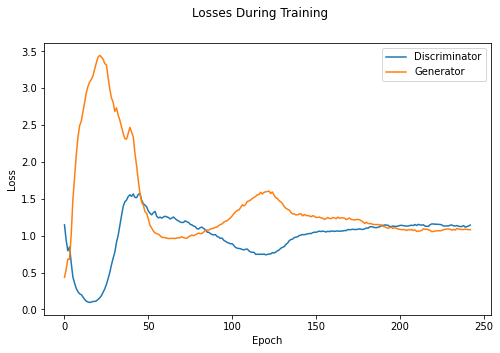

Time for epoch 243 is 1.9613292217254639 sec


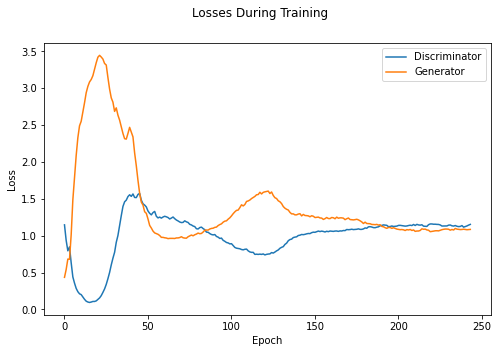

Time for epoch 244 is 1.9619903564453125 sec


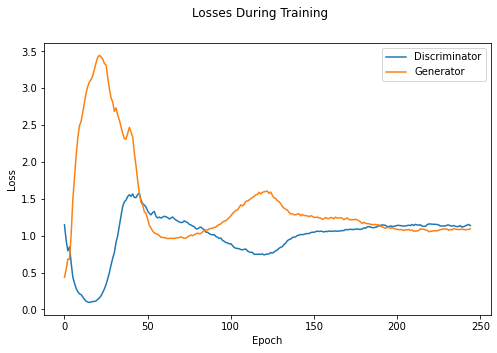

Time for epoch 245 is 1.992236614227295 sec


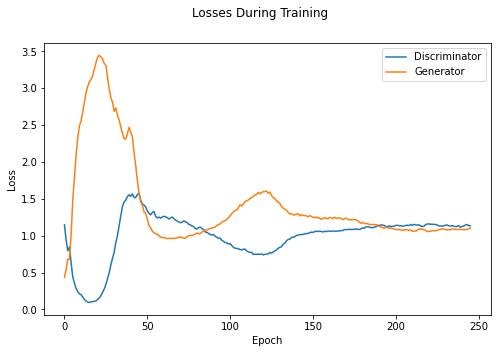

Time for epoch 246 is 1.9166638851165771 sec


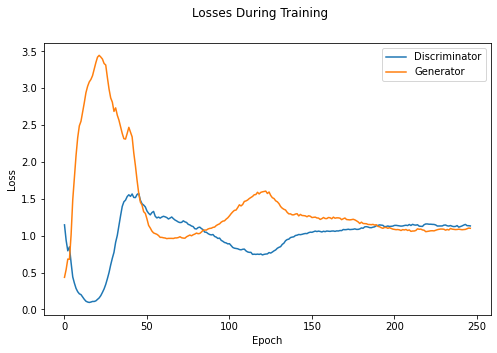

Time for epoch 247 is 1.904189109802246 sec


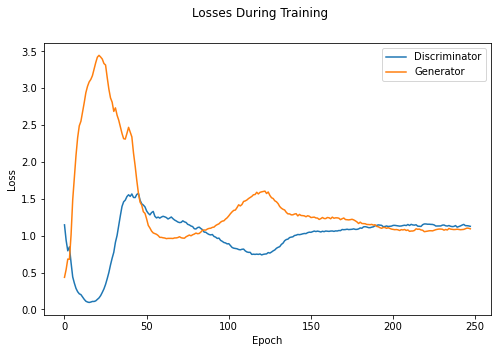

Time for epoch 248 is 1.9097704887390137 sec


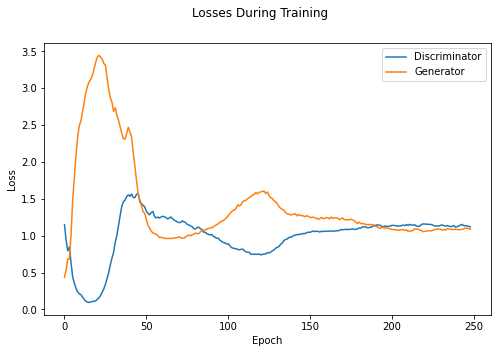

Time for epoch 249 is 1.9096252918243408 sec


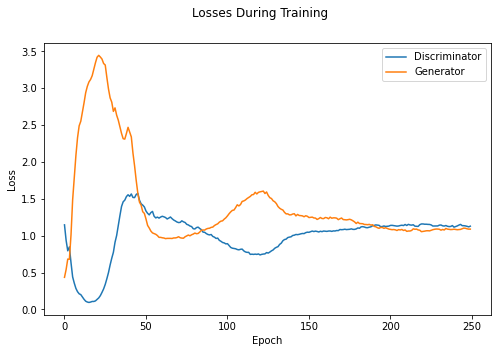

Time for epoch 250 is 1.8978607654571533 sec


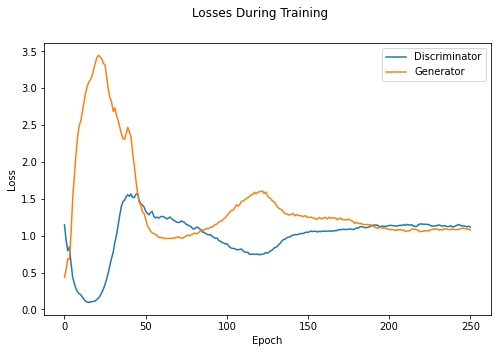

Time for epoch 251 is 2.966031312942505 sec


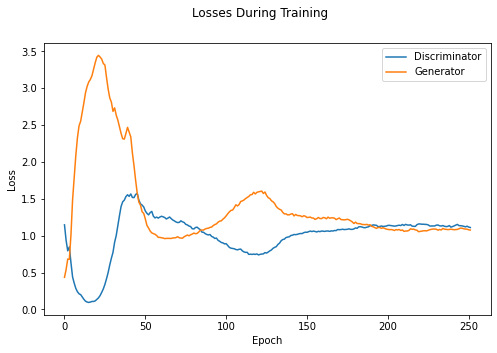

Time for epoch 252 is 1.9272196292877197 sec


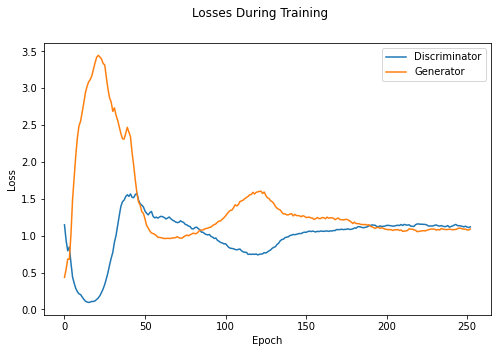

Time for epoch 253 is 3.797030210494995 sec


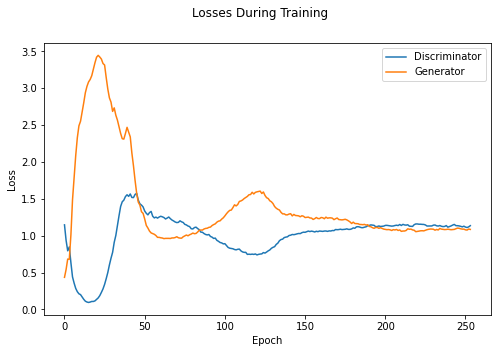

Time for epoch 254 is 1.8757131099700928 sec


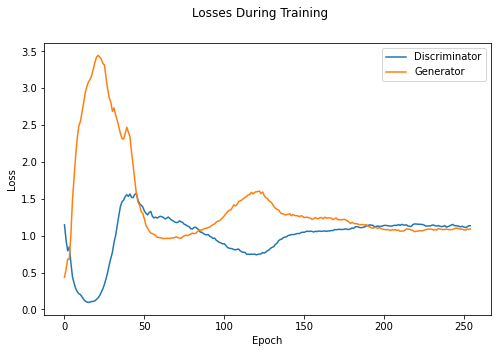

Time for epoch 255 is 1.8567993640899658 sec


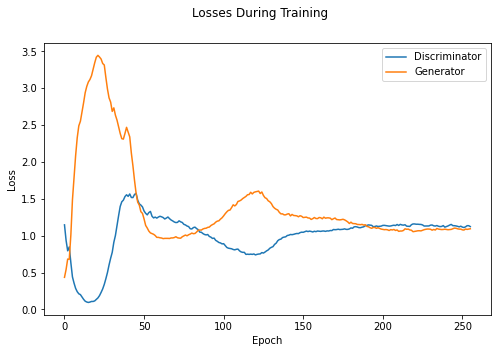

Time for epoch 256 is 1.861055850982666 sec


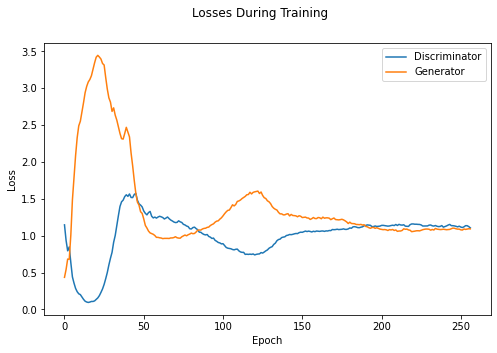

Time for epoch 257 is 1.858022689819336 sec


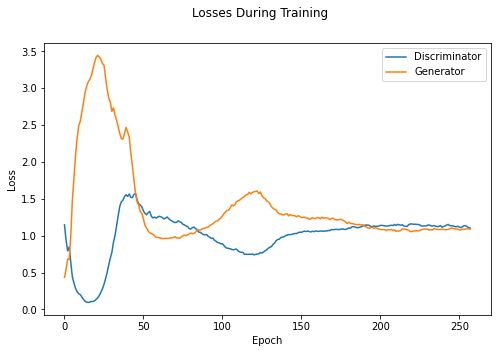

Time for epoch 258 is 1.8396186828613281 sec


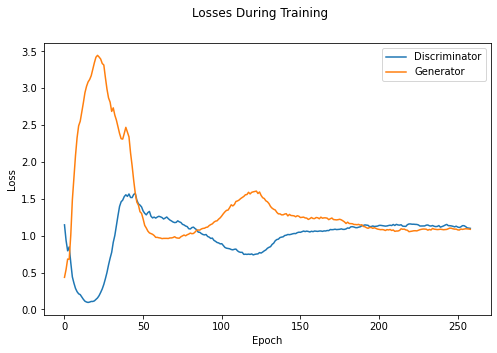

Time for epoch 259 is 1.8698010444641113 sec


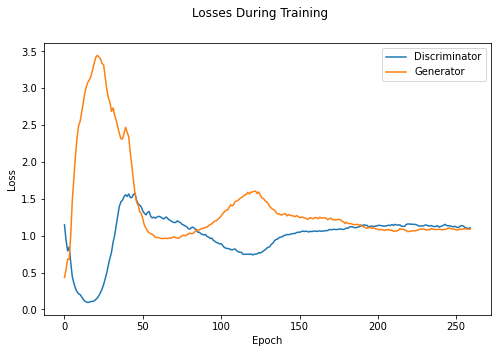

Time for epoch 260 is 1.8176534175872803 sec


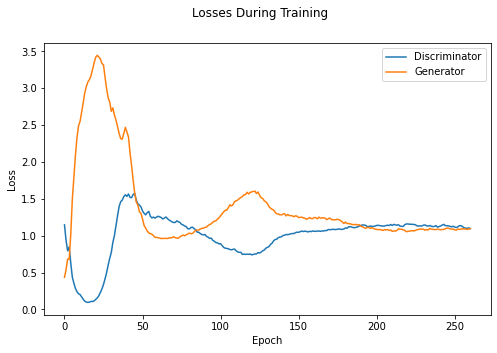

Time for epoch 261 is 1.8503906726837158 sec


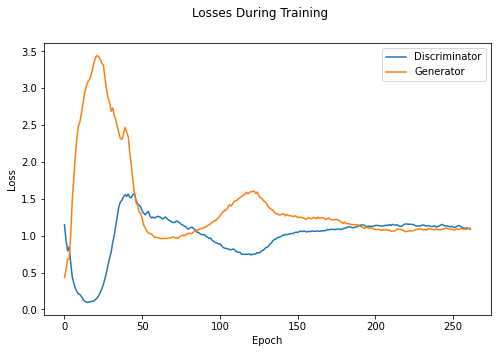

Time for epoch 262 is 1.8577733039855957 sec


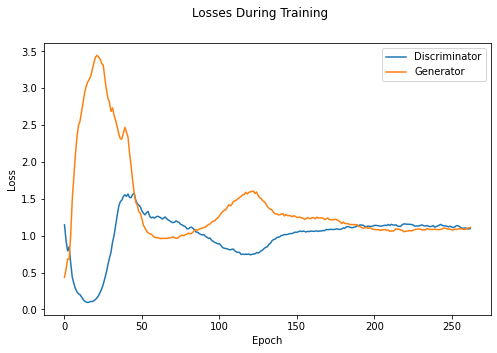

Time for epoch 263 is 1.8162202835083008 sec


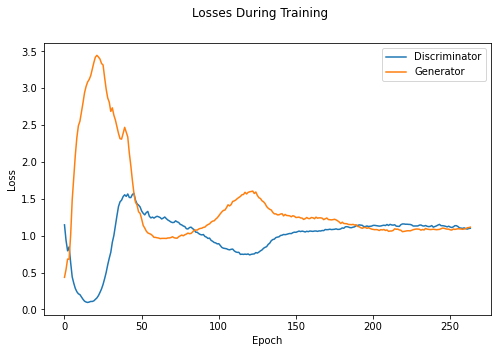

Time for epoch 264 is 1.8321123123168945 sec


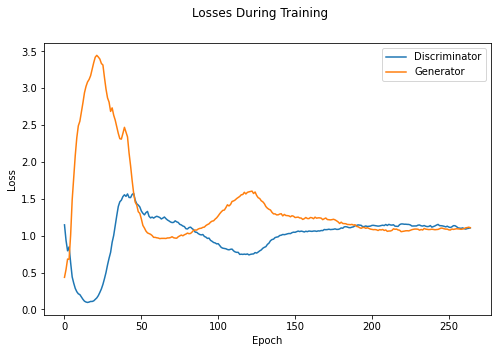

Time for epoch 265 is 1.8401720523834229 sec


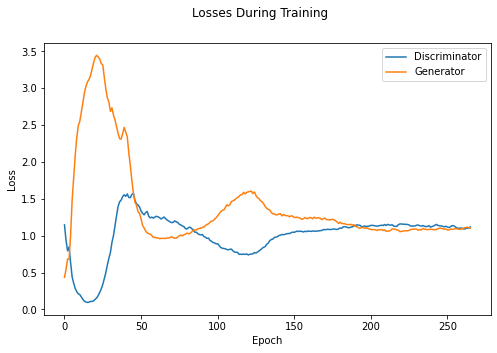

Time for epoch 266 is 3.026414155960083 sec


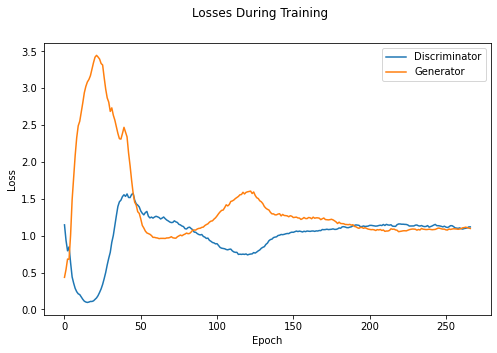

Time for epoch 267 is 2.8150603771209717 sec


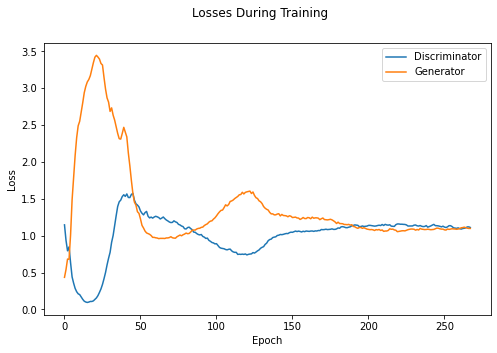

Time for epoch 268 is 1.79136061668396 sec


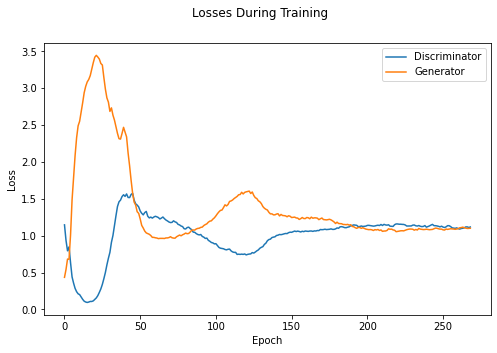

Time for epoch 269 is 1.8212001323699951 sec


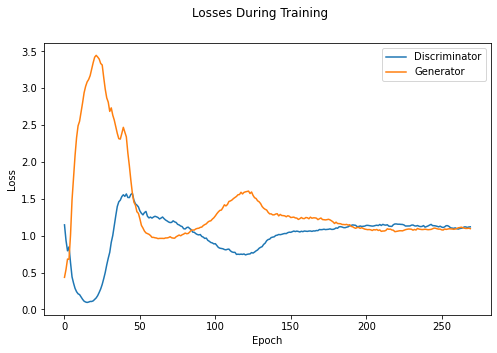

Time for epoch 270 is 1.8531014919281006 sec


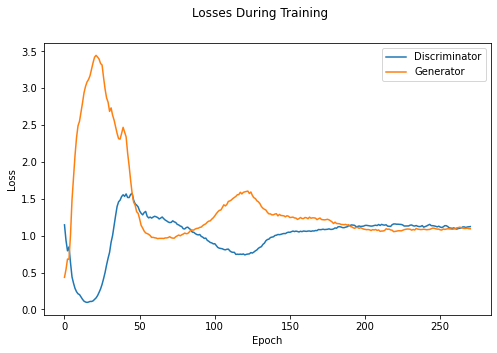

Time for epoch 271 is 1.8191914558410645 sec


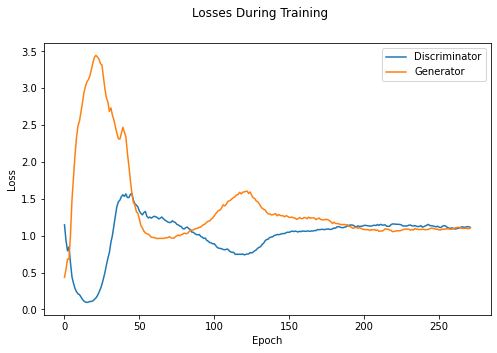

Time for epoch 272 is 1.7991034984588623 sec


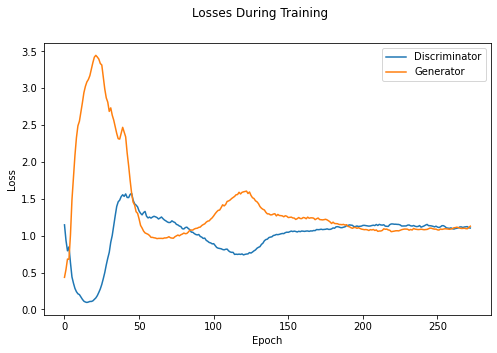

Time for epoch 273 is 3.9726037979125977 sec


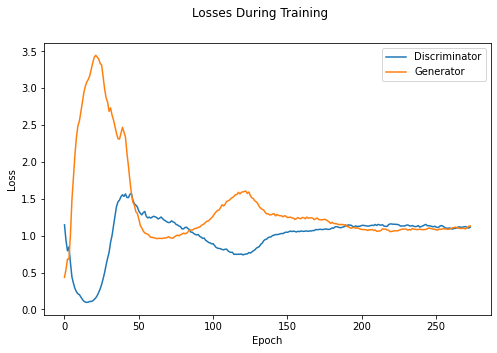

Time for epoch 274 is 1.754786729812622 sec


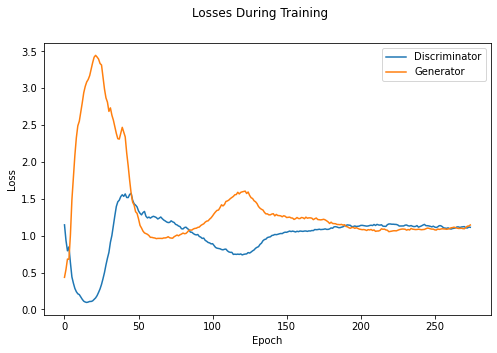

Time for epoch 275 is 1.7583184242248535 sec


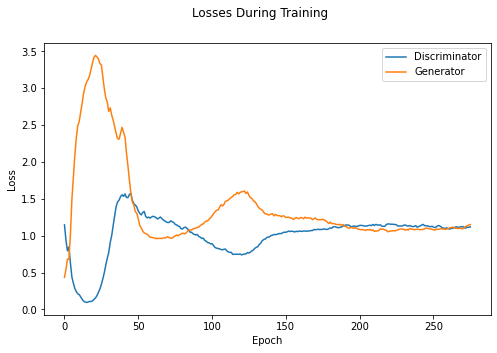

Time for epoch 276 is 3.8929736614227295 sec


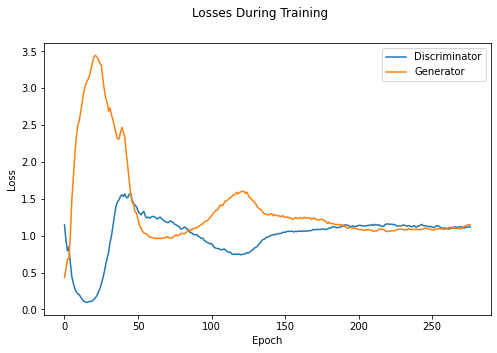

Time for epoch 277 is 1.7417352199554443 sec


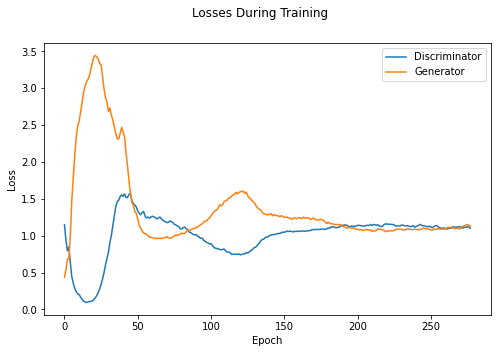

Time for epoch 278 is 2.520888090133667 sec


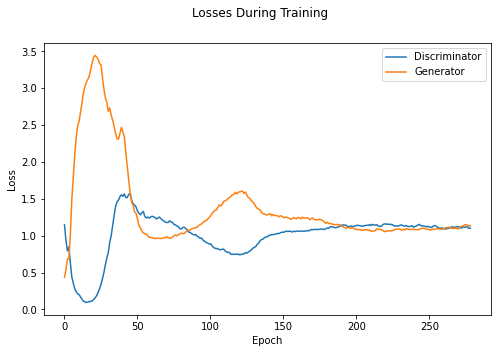

Time for epoch 279 is 1.7859001159667969 sec


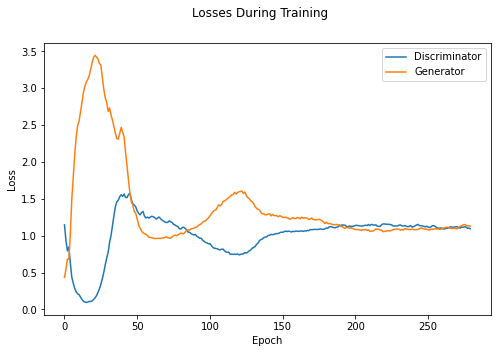

Time for epoch 280 is 1.779651165008545 sec


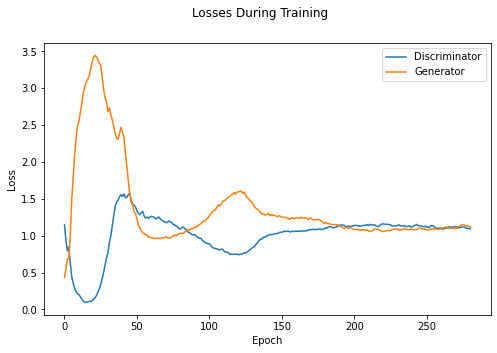

Time for epoch 281 is 2.7809886932373047 sec


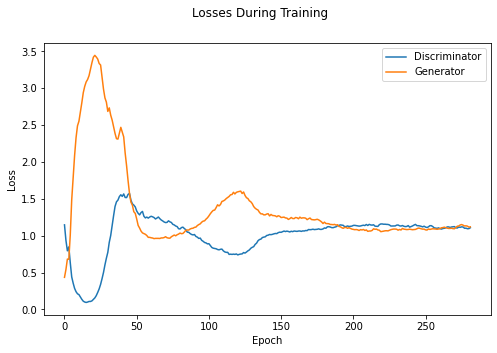

Time for epoch 282 is 1.7090344429016113 sec


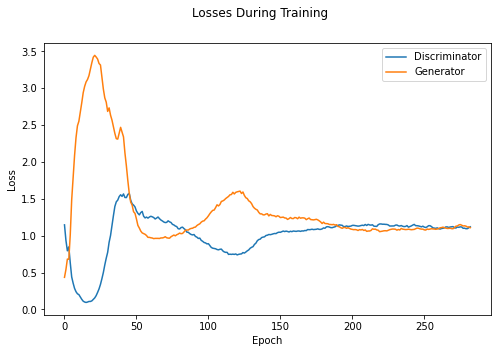

Time for epoch 283 is 1.7606894969940186 sec


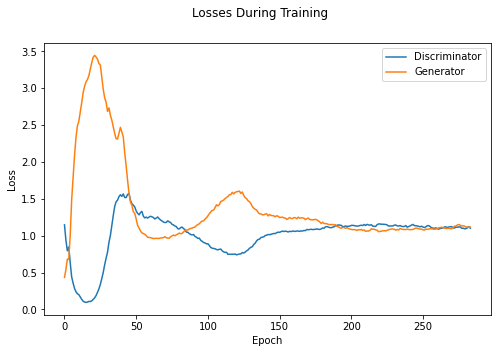

Time for epoch 284 is 3.475569248199463 sec


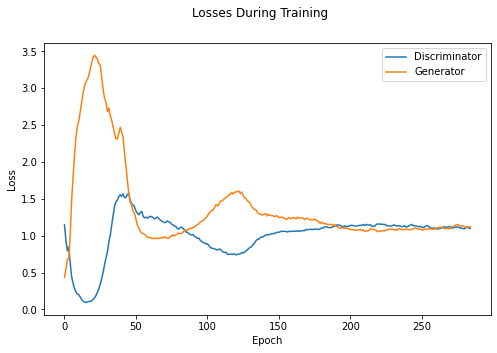

Time for epoch 285 is 3.229607582092285 sec


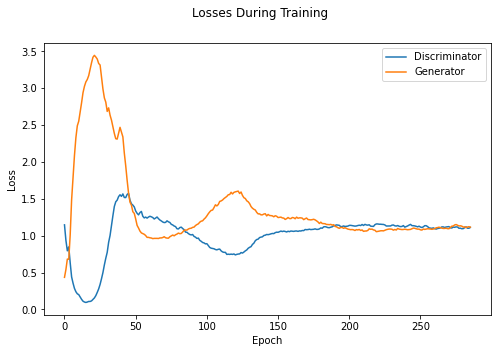

Time for epoch 286 is 3.697542428970337 sec


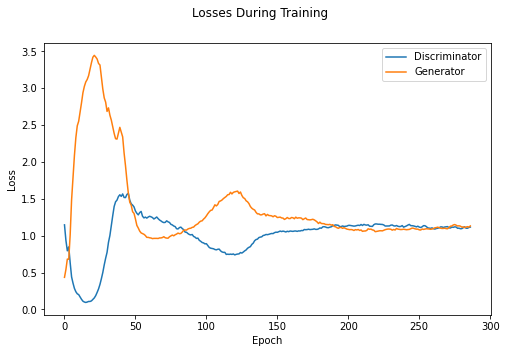

Time for epoch 287 is 2.101823091506958 sec


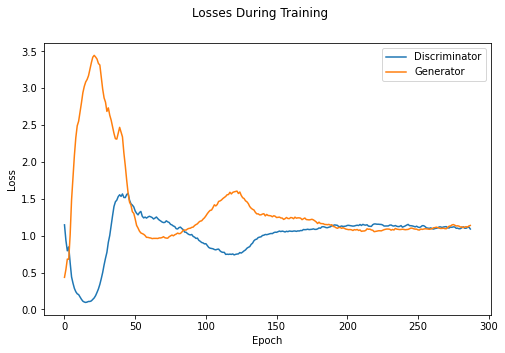

Time for epoch 288 is 3.740382671356201 sec


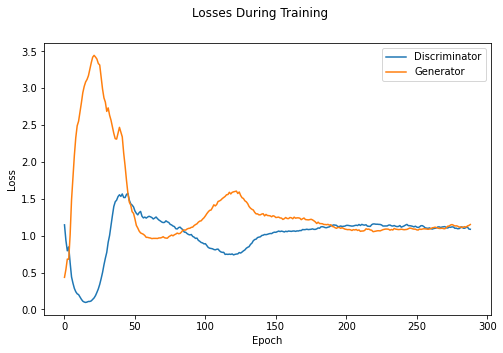

Time for epoch 289 is 1.7185051441192627 sec


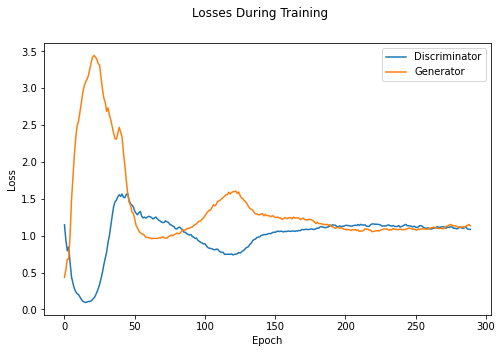

Time for epoch 290 is 3.5123562812805176 sec


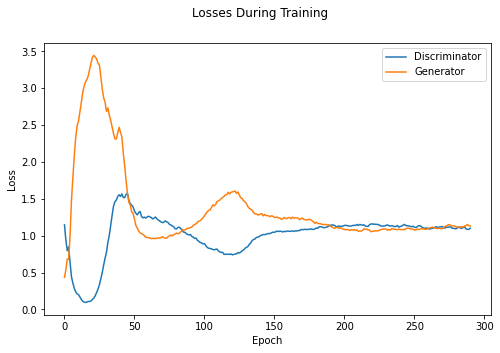

Time for epoch 291 is 2.139979839324951 sec


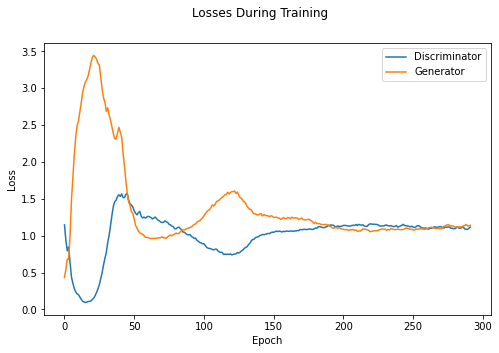

Time for epoch 292 is 1.9539921283721924 sec


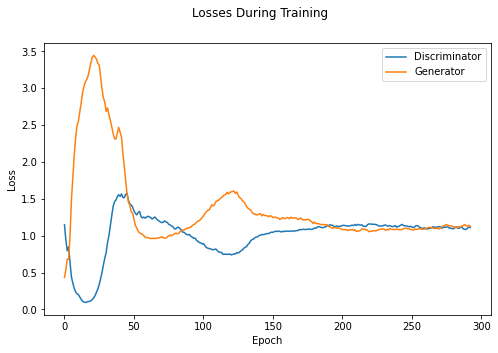

Time for epoch 293 is 1.9570183753967285 sec


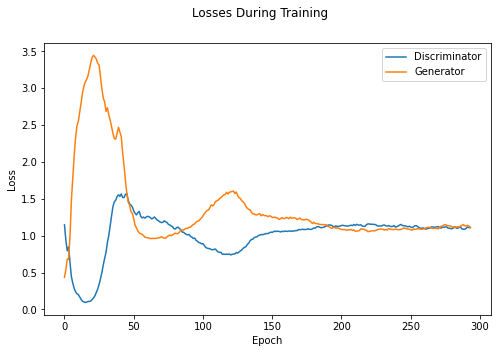

Time for epoch 294 is 2.0047359466552734 sec


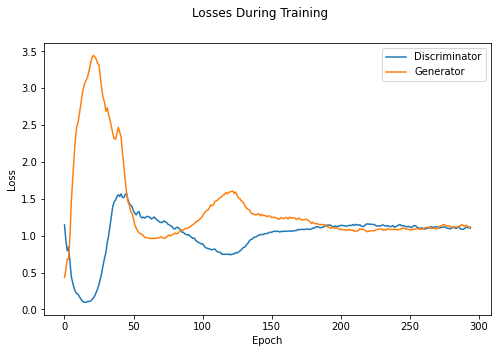

Time for epoch 295 is 3.5072524547576904 sec


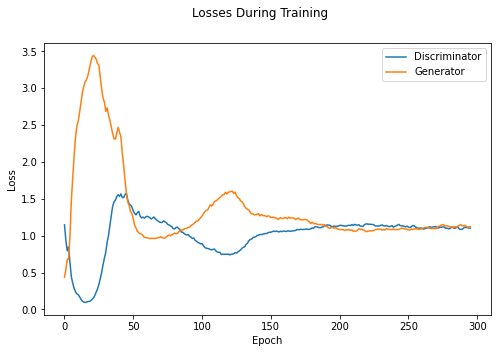

Time for epoch 296 is 1.9995429515838623 sec


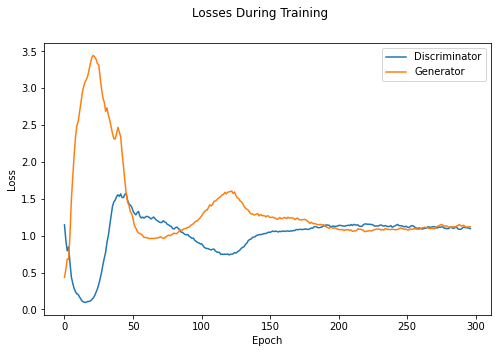

Time for epoch 297 is 1.9786853790283203 sec


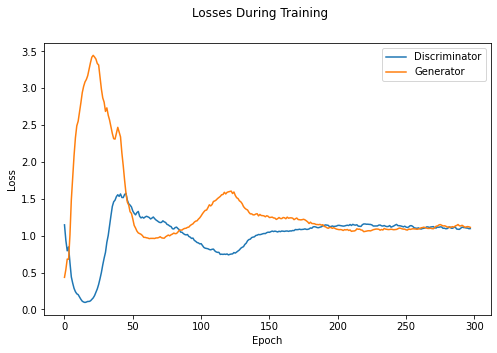

Time for epoch 298 is 1.905245065689087 sec


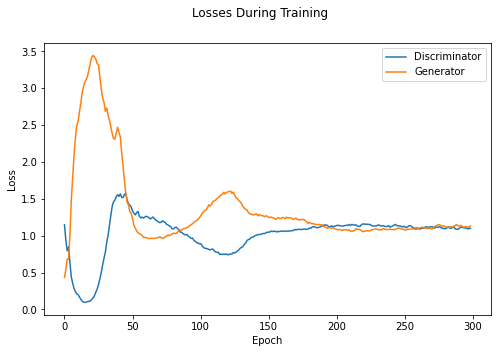

Time for epoch 299 is 1.95646333694458 sec


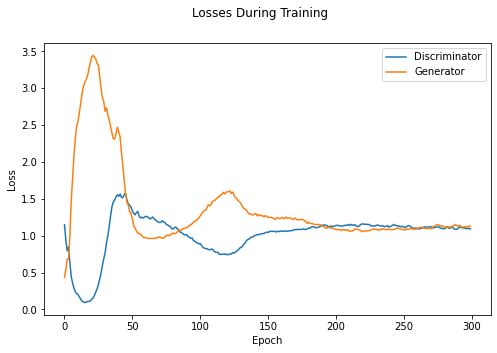

Time for epoch 300 is 1.8904056549072266 sec


In [712]:
epochs = 300
G_loss = []
D_loss = []
train(train_dataset, epochs)

In [700]:
num_examples = 10

vol =  np.repeat(1,num_examples).reshape(-1, 1)
noise = np.random.randn(num_examples,noise_dim)
noise_with_vol = np.concatenate((noise, vol), axis=1)

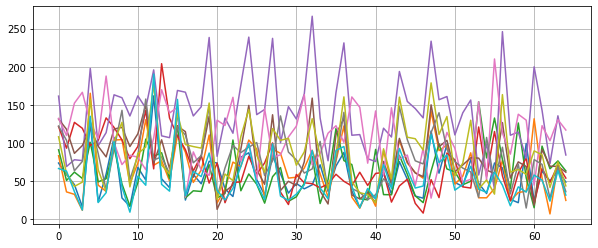

In [701]:
gen_out = generator(noise_with_vol, training=False)
result = tf.squeeze(gen_out)
paths = (result.numpy())

plt.figure(figsize=(10,4))
plt.plot(paths.T)
plt.grid(True)
plt.show()

In [474]:
#Saving the model to rerun later.

model_json = generator.to_json()
with open("Generator_C_BlackScholes64_v3.json", "w") as json_file:
    json_file.write(model_json)
    
generator.save_weights("Generator_C_BlackScholes64_v3.h5")
print("Saved generator to disk")

model_json = discriminator.to_json()
with open("Discriminator_C_BlackScholes64_v3.json", "w") as json_file:
    json_file.write(model_json)
    
discriminator.save_weights("Discriminator_C_BlackScholes64_v3.h5")
print("Saved discriminator to disk")

Saved generator to disk
Saved discriminator to disk


#### Comparison with SDE data.

Here, we compare the distributions of our generated data with the distribution of the GAN output. We can do this for various sigma values.

In [222]:
from keras.models import model_from_json

In [233]:
json_file = open('Generator_BlackScholes64_v8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
generator = model_from_json(loaded_model_json)
# load weights into new model
generator.load_weights("Generator_BlackScholes64_v8.h5")
print("Loaded model from disk")

Loaded model from disk


In [237]:
noise = np.random.randn(1000,noise_dim)
gen_out = generator(noise, training=False)
result = tf.squeeze(gen_out) 
paths = (result.numpy())

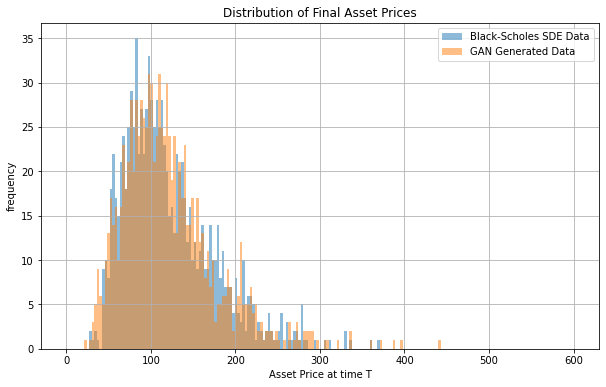

In [238]:
plt.figure(figsize=(10,6))

bins = np.linspace(0, 600,200)
plt.hist(S[-1,:1000], bins=bins, alpha=0.5, label="Black-Scholes SDE Data")
plt.hist(paths[:,-1], bins=bins, alpha=0.5, label="GAN Generated Data")

plt.title("Distribution of Final Asset Prices")

plt.xlabel("Asset Price at time T")
plt.ylabel("frequency")
plt.legend()
plt.grid(True)

plt.show()

#### Kolmogorov-Smirnov Test for two samples.

In [239]:
from scipy.stats import ks_2samp

ks_2samp(S[-1,:1000], paths[:,-1])

KstestResult(statistic=0.029, pvalue=0.7946637387576738)

Using 1000 samples, test result gives p-value >0.05 and we can't reject the null hypothesis that the two populations were drawn from the same distribution.

NB. Could bootstrap this KS test result.

#### Generating Log Returns from GAN data.

In [50]:
GAN_log_returns_array = np.zeros_like(paths.T)
GAN_log_returns_array.shape

(65, 10000)

In [51]:
for j in range(10000):
    for k in range(0, len(paths.T)-1):
        GAN_log_returns_array[k, j] = np.log(paths.T[k, j] / paths.T[k - 1, j])

In [52]:
GAN_log_returns_array = GAN_log_returns_array[1:]
GAN_log_returns_array.shape

(64, 10000)

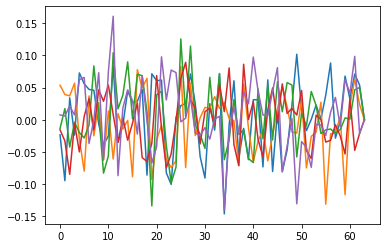

In [95]:
#for log_ret in 
for log_ret in range(5,10):
    plt.plot(GAN_log_returns_array.T[log_ret])

#### Deriving volatility parameter from GAN data

derive the volatility using the fact that $r \sim N(0,\sigma^2)$ which is true for the Black Scholes model.

In [106]:
#create a function to derive the volatility of S given the log returns

def get_vol(log_rets):
    
    mean_log_rets = np.mean(log_rets)
    sq_diff = (log_rets - mean_log_rets) ** 2
    var = np.mean(sq_diff)
    vol = np.sqrt(var)

    return vol

In [134]:
SDE_vols = []
GAN_vols = []

for i in range(0,10000):
    GAN_vols.append(get_vol(GAN_log_returns_array.T[i]))
    SDE_vols.append(get_vol(log_returns_array.T[i]))

volatility_comparison = {'SDE Volatility': np.asarray(SDE_vols), 'GAN Volatility': np.asarray(GAN_vols)}
volatility_comparison_df = pd.DataFrame(volatility_comparison)


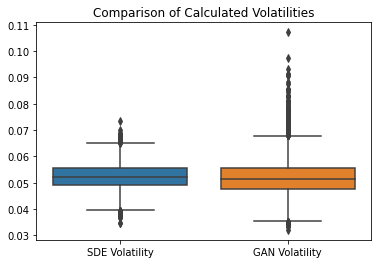

In [141]:
a = sns.boxplot(data = volatility_comparison_df).set(title='Comparison of Calculated Volatilities')

#### Distribution of returns between both methods of generation




In [251]:
flat_GAN_returns = GAN_log_returns_array[:,:1000].flatten()
flat_SDE_returns = log_returns_array[:,:1000].flatten()

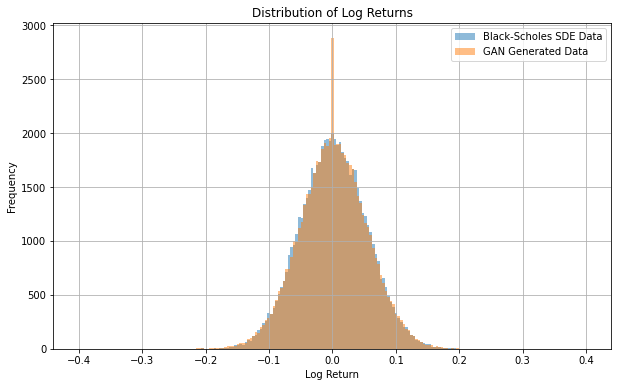

In [256]:
plt.figure(figsize=(10,6))

bins = np.linspace(-0.4, 0.4,200)
plt.hist(flat_SDE_returns, bins=bins, alpha=0.5, label="Black-Scholes SDE Data")
plt.hist(flat_GAN_returns, bins=bins, alpha=0.5, label="GAN Generated Data")

plt.title("Distribution of Log Returns")

plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.show()